## Process TCRseq and RNAseq

**RNA**
- pearson correlation between pORG and --
- deconvolution
- GSVA
- gene expression
- VIPER

**TCR**
- calculate shared/clonal TCR clonotypes
- Count KRAS specific clonotypes
- Calculate Shannon entropy, clonality and Simpson's D


In [1]:
#load libraries

import os
import itertools
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import math
import warnings
from scipy.stats import pearsonr
import importlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm, gridspec
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
mpl.rc('figure', max_open_warning = 0)

import sklearn
from sklearn.preprocessing import minmax_scale, scale, FunctionTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import lifelines
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import multivariate_logrank_test
from lifelines import exceptions
warnings.filterwarnings("ignore",category = exceptions.ApproximationWarning)

import scipy
from scipy import stats
from scipy.stats import entropy, norm
from scipy.spatial import cKDTree
import networkx as nx
import statsmodels
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
import pylab

import anndata
from anndata import AnnData
from bioinfokit import analys, visuz

#import phenograph

codedir = os.getcwd()#'/home/groups/BCC_Chin_Lab/ChinData/Cyclic_Analysis/cmIF_2021-05-03_PDAC/U54-TMA-9/Jenny'  #
#rootdir = '/home/groups/BCC_Chin_Lab/ChinData/Cyclic_Analysis/cmIF_2021-05-03_PDAC/U54-TMA-9'
# os.chdir('/home/groups/graylab_share/Chin_Lab/ChinData/engje/Data')
# from mplex_image import visualize as viz, process, preprocess, normalize, mics, mpimage
# from spatial import spatial

import plotly.express as px
from statannotations.Annotator import Annotator
from itertools import combinations
import util
np.random.seed(712)

#change to correct directory
datadir = f'{codedir}/data'
s_date = '20230914'
os.chdir(codedir)
if not os.path.exists(s_date):
    os.mkdir(s_date)
    os.mkdir(f'{s_date}/Survival_Plots')
%matplotlib inline

# Table of contents <a name="contents"></a>

1. [**RNAseq data for validation**](#rna) [Pearson Correlation](#rnacorr) [DEseq2](#rnadeseq) [Categorical GSVA](#rnagsva)
2. [TCRseq data](#tcr) [**TCR number**](#tcrnum) [**TCR pie charts**](#tcrpie) [TCRseq metrics](#tcr2) 



### RNAseq analysis <a name="rna"></a> 

[contents](#contents)

ran DESeq2, GSVA, deconvolution, VIPER

In [44]:
df_patient = pd.read_excel('Supplemental_Data/Supplemental_Dataset_1.xlsx',sheet_name=0,
                          index_col=0)

## deconvolution

In [3]:
# load deconvolution
df_deconv = pd.DataFrame()
#for s_deconv in ['QTS','EPC']: #QTS is  immune freq, XCL and 'MCP', has states
ls_deconv = ['QTS','EPC','MCP']
ls_deconv = ['XCL']
#ls_deconv = ['QTS']
for s_deconv in ls_deconv:#,'MCP''XCL'
    df_epc = pd.read_csv(f'results/results_{s_deconv}_Tempus300.csv').drop('Unnamed: 0',axis=1).set_index('cell_type')
    if len(ls_deconv) >1:
        df_epc.index = [f'{item} {s_deconv}' for item in df_epc.index]
    df_deconv = pd.concat([df_deconv,df_epc])
ls_marker = df_deconv.index.tolist()
#df_deconv.T.head()

In [4]:
s_primary = 'Primaries'
idx = 0

df_pORG_55 = pd.read_excel('annotation/GSVA_PrimarySamplesReports.xlsx',sheet_name='GSVA_DGE_cpms_Primaries')
df_pORG_55.set_index('Sample',inplace=True)

df_pORG = pd.read_csv(f'annotation/GSVA_{s_primary}_pORG_0.14_0.15.tsv',sep='\t',index_col=0)#.iloc[:,[idx]]
df_pSUB = pd.read_csv(f'annotation/GSVA_{s_primary}_Kallisto55_pSUB1e-4and1e-5.tsv',sep='\t',index_col=0)#.iloc[:,[idx]]
df_deconv = df_deconv.T.merge(df_pORG,left_index=True,right_index=True).merge(df_pSUB,left_index=True,right_index=True)
#add newst pORG
df_deconv = df_deconv.merge(df_pORG_55,left_index=True,right_index=True,suffixes=('','__'))

# #ids
# df_ids = pd.read_excel(f'{codedir}/annotation/Simplified_Public_IDs_Key.xlsx',sheet_name='RnaSeqKey')
# df_ids.columns = [item.replace('.','_') for item in df_ids.columns]
# df_patient['OPTR'] = df_patient.Public_Patient_ID.map(dict(zip(df_ids.Biolibrary_Subject_ID,df_ids.OPTR.astype('int64').astype('str'))))
# df_patient['RNASpecID'] = [item + '-T' for item in df_patient.OPTR.fillna('')]
# #check all are there
# print(set(df_deconv.index) - set(df_patient.RNASpecID))
print(len(df_deconv))

# df_deconv = df_deconv.merge(df_patient.loc[:,['RNASpecID','Tumor_Cellularity_by_DNA_Primary']].set_index('RNASpecID'),
#                 left_index=True,right_index=True)
print(len(df_deconv))

204
204


/var/folders/v9/4cccs75d7fn47pkrfvyzr9ysd4jjjl/T/ipykernel_75555/4167899933.py:24: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  p_vals = pval.applymap(lambda x: ''.join(['*' for t in [0.05] if x<=t])) #0.001,0.005,


Text(0.5, 1.0, 'XCL Score Correlation')

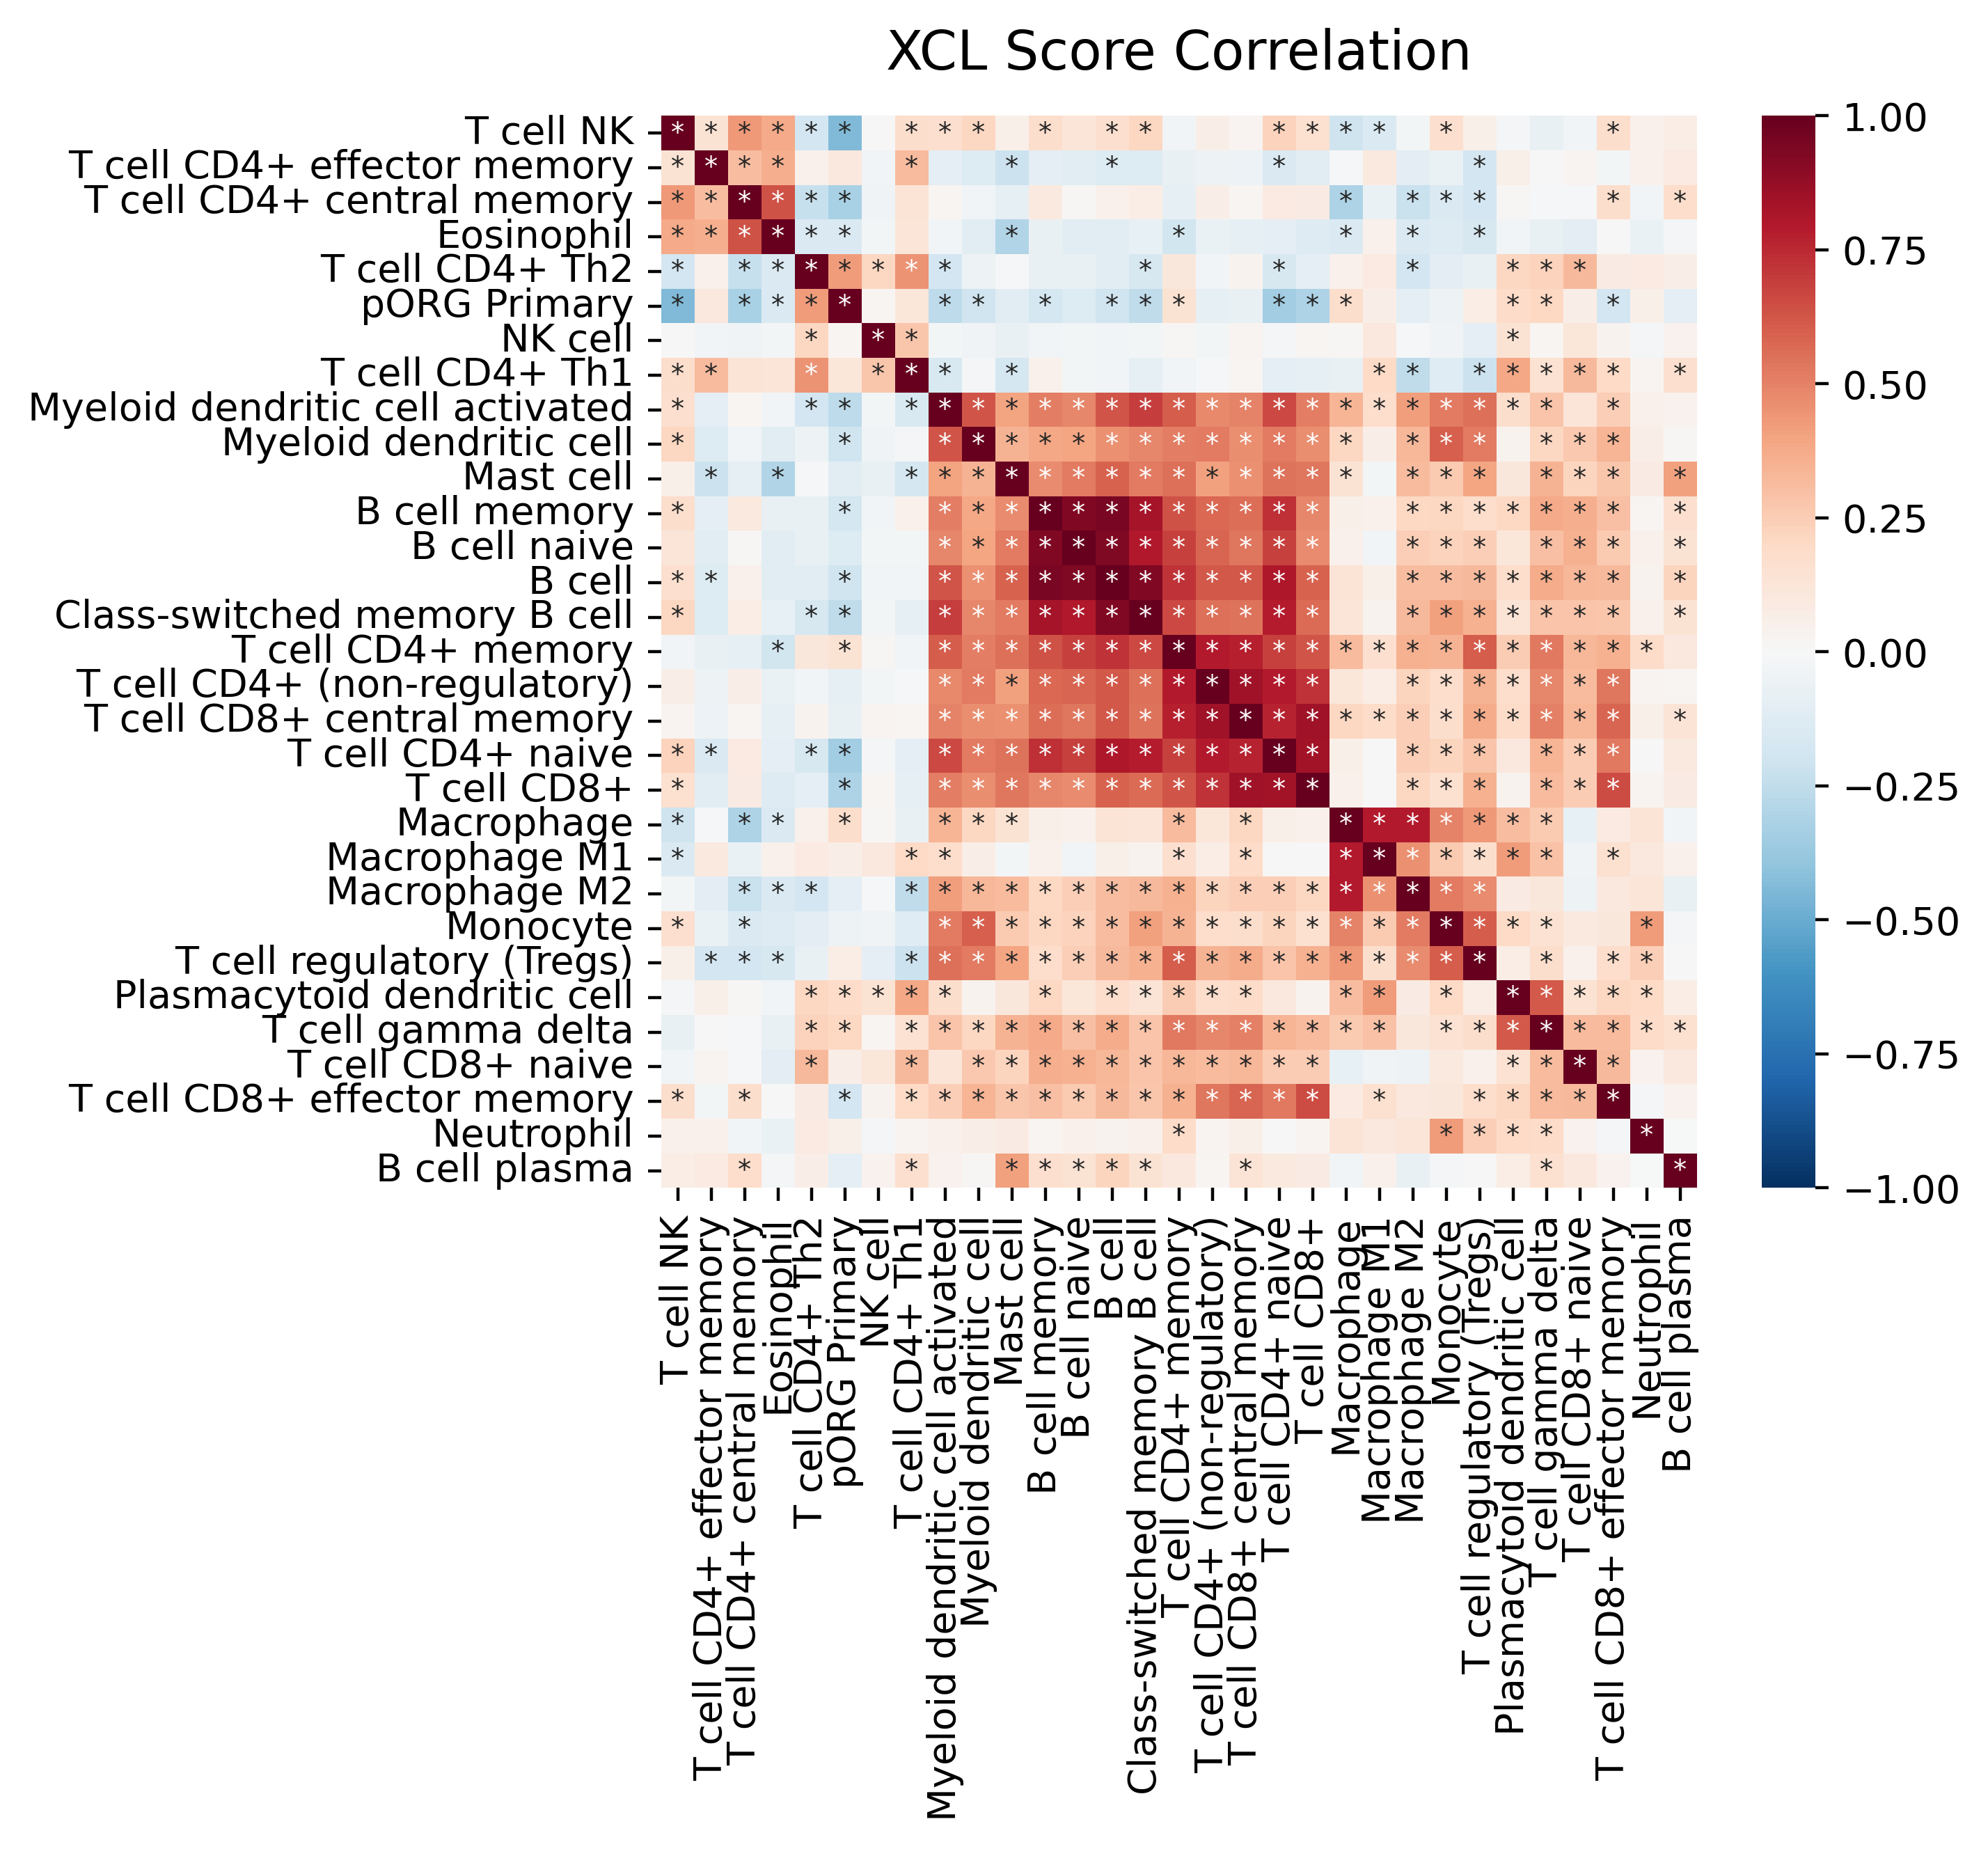

In [5]:
#correlation heatmap

ls_drop = [ 'Tumor_Cellularity','stroma score','Common lymphoid progenitor',
 'Common myeloid progenitor','Granulocyte-monocyte progenitor','uncharacterized cell',
 'immune score','microenvironment score','uncharacterized cell QTS','uncharacterized cell EPC',
           'Cancer associated fibroblast','Endothelial cell','Hematopoietic stem cell',]

df_all = df_deconv.loc[:,ls_marker + ['trim_padj_0.2_pORG_Up_55_Genes']] #'pORG.14',,'Tumor_Cellularity_by_DNA_Primary'
df_all.rename({'trim_padj_0.2_pORG_Up_55_Genes':'pORG Primary',
              'Tumor_Cellularity_by_DNA_Primary':'Tumor_Cellularity'},axis=1,inplace=True)

df_all = df_all.loc[:,~df_all.columns.isin(ls_drop)]
if len(ls_deconv) > 1:
    s_deconv= ".".join(ls_deconv)
dim = (5,4)
if s_deconv == 'XCL':
    dim = (6,5)
g = sns.clustermap(df_all.corr())
plt.close()
categories_order = df_all.corr().iloc[g.dendrogram_col.reordered_ind,:].index.tolist()
df_all = df_all.loc[:,categories_order]
rho = df_all.corr()
pval = df_all.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p_vals = pval.applymap(lambda x: ''.join(['*' for t in [0.05] if x<=t])) #0.001,0.005,
fig, ax = plt.subplots(figsize=dim,dpi=400)
sns.heatmap(df_all.corr(), vmin=-1, vmax=1, annot=p_vals, fmt = '',annot_kws={'size':'x-small'},
            cmap='RdBu_r',ax=ax,yticklabels=1,xticklabels=1)
ax.set_title(f'{s_deconv} Score Correlation', fontdict={'fontsize':14}, pad=12)

In [6]:
# #new scores: save identified
# df_id = pd.read_csv('Patient_IDs.csv',index_col=0)#.rename({'Biolibrary.Subject.ID':'Public_Patient_ID',
#                                                    #       'Public.Specimen.ID':'Public_Specimen_ID'},axis=1)
# df_scores = pd.DataFrame()

# ls_score = ['GSVA_PrimarySamplesReports.xlsx','GSVA_MetSamplesReports.xlsx','GSVA_AllSamplesReports.xlsx']
# for s_score in ls_score:
#     df = pd.read_excel(f'./annotation/{s_score}',sheet_name=1)
#     df['Public_Specimen_ID'] = df.Sample.map(dict(zip(df_id.loc[:,'OPTR.Specimen.ID'],df_id.loc[:,'Public.Specimen.ID'])))
#     df['Group'] = s_score.split('Samples')[0]
#     #df.drop('Sample',axis=1,inplace=True)
#     df_scores = pd.concat([df_scores,df])

# df_scores.to_csv('20230608_GSVA_Scores.csv')


## gene, GSVA correlation

In [5]:
# using non-public IDs, can't share files

In [10]:
#load data
df_patient = pd.read_excel('Supplemental_Data/Supplemental_Dataset_1.xlsx',sheet_name=0,
                          index_col=0)
#using
df_gsva = pd.read_csv('../R/results_GSVA_2.csv',index_col=0)
df_gsva.index = [item.replace('X','').replace('.','-') for item in df_gsva.index]
df_gsva.rename({'neutrophil activation involved in immune response':'neut. act. invol. in imm. resp.',
               'T cell activation involved in immune response':'T cell act. invol. in imm. resp.'},axis=1,inplace=True)

#NOTE: upload the annotations
df_annotation = pd.read_csv('../R/DESeq2_annotation.csv',index_col=0)
d_annotation = dict(zip(df_annotation.gene_id,df_annotation.gene_name))

df_vst = pd.read_csv('../R/DESeq2_matrix_downstream.csv',index_col=0) #2
df_vst.index = df_vst.index.map(d_annotation)

#df_gene = df_pri.merge(df_vst.T,left_index=True,right_index=True) #old pORG
df_gene = df_vst.T.copy().reset_index().rename({'index':'ID'},axis=1)
df_gene.rename({'Patient Specimen ID':'Public_Specimen_ID'},axis=1,inplace=True)
df_gene = df_gene.set_index('ID')
df_gene = df_gene[~df_gene.index.duplicated()]
#

In [30]:
# # viper
# df_viper = pd.read_excel(f'Supplemental_Data/Supplemental_Dataset_6.xlsx',index_col=0)
# df_viper.columns = [item[0:-2] for item in df_viper.columns]
# df_viper = df_viper.T

## gene correlation <a name="rnacorr"></a> 

[contents](#contents)

In [57]:
# correlation heatmap TCR data with genes, hallmarks and deconvolution (plus pORG
df_tcr = pd.read_csv(f'annotation/20231012_Patient_Metadata_TCR_Metrics.csv',index_col=0)

ls_scores =['pORG_0.2_Primary']#['trim_padj_0.2_pORG_Up_55_Genes','Kallisto55_pSUB1e-04','PurIST Score']
ls_tcr = ['Simpsons_Evenness_Tumor', 'Simpsons_Evenness_Blood', 
       'Shannon_Entropy_Tumor','Templates_per_ng',
       'Normalized_Shannon_Entropy_Tumor', 'Shannon_Entropy_Blood',
       'Normalized_Shannon_Entropy_Blood', 'Fraction Shared TCRs',
       'Simpsons_Diversity_Tumor','Age at Diagnosis',
       'Simpsons_Diversity_Blood', 'Clonality_Tumor', 'Clonality_Blood',
       'Percent Tumor Distinct Clones','pORG_0.2_Primary']

ls_tcr = ['Simpsons_Evenness_Tumor',# 'Simpsons_Evenness_Blood', 
       'Shannon_Entropy_Tumor','Templates_per_ng',
       #'Normalized_Shannon_Entropy_Tumor', 'Shannon_Entropy_Blood',
       #'Normalized_Shannon_Entropy_Blood', 'Fraction Shared TCRs',
       #'Simpsons_Diversity_Tumor','Age at Diagnosis',
       #'Simpsons_Diversity_Blood', 
          'Clonality_Tumor',# 'Clonality_Blood',
       #'Percent Tumor Distinct Clones',
      'Productive_Rearrangements',#'pORG_Primary'
    ]

ls_gsva = df_gsva.columns[~df_gsva.columns.str.contains('HALLMARK')]
ls_gsva = ls_gsva.drop('Stem (dan broeck)').tolist()
ls_hallmark = df_gsva.columns[df_gsva.columns.str.contains('HALLMARK')].tolist()
ls_hallmark_select = ['HALLMARK_MYC_TARGETS_V1',#'HALLMARK_IL2_STAT5_SIGNALING','HALLMARK_IL6_JAK_STAT3_SIGNALING','HALLMARK_INFLAMMATORY_RESPONSE',
        'HALLMARK_E2F_TARGETS', 'HALLMARK_MITOTIC_SPINDLE',#'HALLMARK_DNA_REPAIR',
       'HALLMARK_MTORC1_SIGNALING','HALLMARK_G2M_CHECKPOINT','neutrophil_degranulation',
              'T cells','B cells','REACTOME_NEUTROPHIL_DEGRANULATION','GOCC_AZUROPHIL_GRANULE',
               'GOCC_TERTIARY_GRANULE','GOCC_SPECIFIC_GRANULE']

ls_gsva_ifn = ['T cells','B cells','response to type II interferon',#'HALLMARK_MYC_TARGETS_V1',
               'cellular response to type I interferon','IRDS',]
ls_krt_select = ['CXCL5','CDC42','RAB11A','NUMB','HPSE','LCN2','MPO']
ls_krt= []

In [58]:
ls_test = ['MKI67','HLA-DQB1','HLA-DRB1','HLA-DRB9','HLA-DQA1','HLA-DRB5',
 'HLA-DOA', 'HLA-DMA','HLA-DRA','HLA-DQB1-AS1','HLA-DPB1','HLA-DPB2',
 'HLA-DRB6','HLA-DPA1','HLA-DQB2','HLA-DQA2','HLA-DOB','HLA-DMB']

In [59]:
df_plot = df_gene.merge(df_gsva.loc[:,ls_gsva + ls_hallmark], #loc[~df_gene.loc[:,ls_scores[0]].isna(),:]
                    left_index=True,right_index=True)
#get IDs
d_ids = pd.read_excel(f'{codedir.split("Liver_Lung_PDAC")[0]}MethodsAndReferencesSupplementalData/OLD Versions/Simplified_Public_IDs_Key.xlsx',sheet_name=None)
df_id = d_ids['RnaSeqKey']
df_plot['Public_Patient_ID'] = df_plot.index.map(dict(zip(df_id.loc[:,'OPTR.Specimen.ID'],df_id.loc[:,'Biolibrary.Subject.ID'])))
#df_plot.dropna().set_index('Public_Patient_ID').to_csv(f'results/Patient_summary_GSVA.csv')

df_plot = df_plot.merge(df_patient,on='Public_Patient_ID',how='left')

/var/folders/v9/4cccs75d7fn47pkrfvyzr9ysd4jjjl/T/ipykernel_76559/1629978696.py:33: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  p_vals = pval.applymap(lambda x: ''.join(['*' for t in [0.05] if x<=t])) #0.001,0.005,


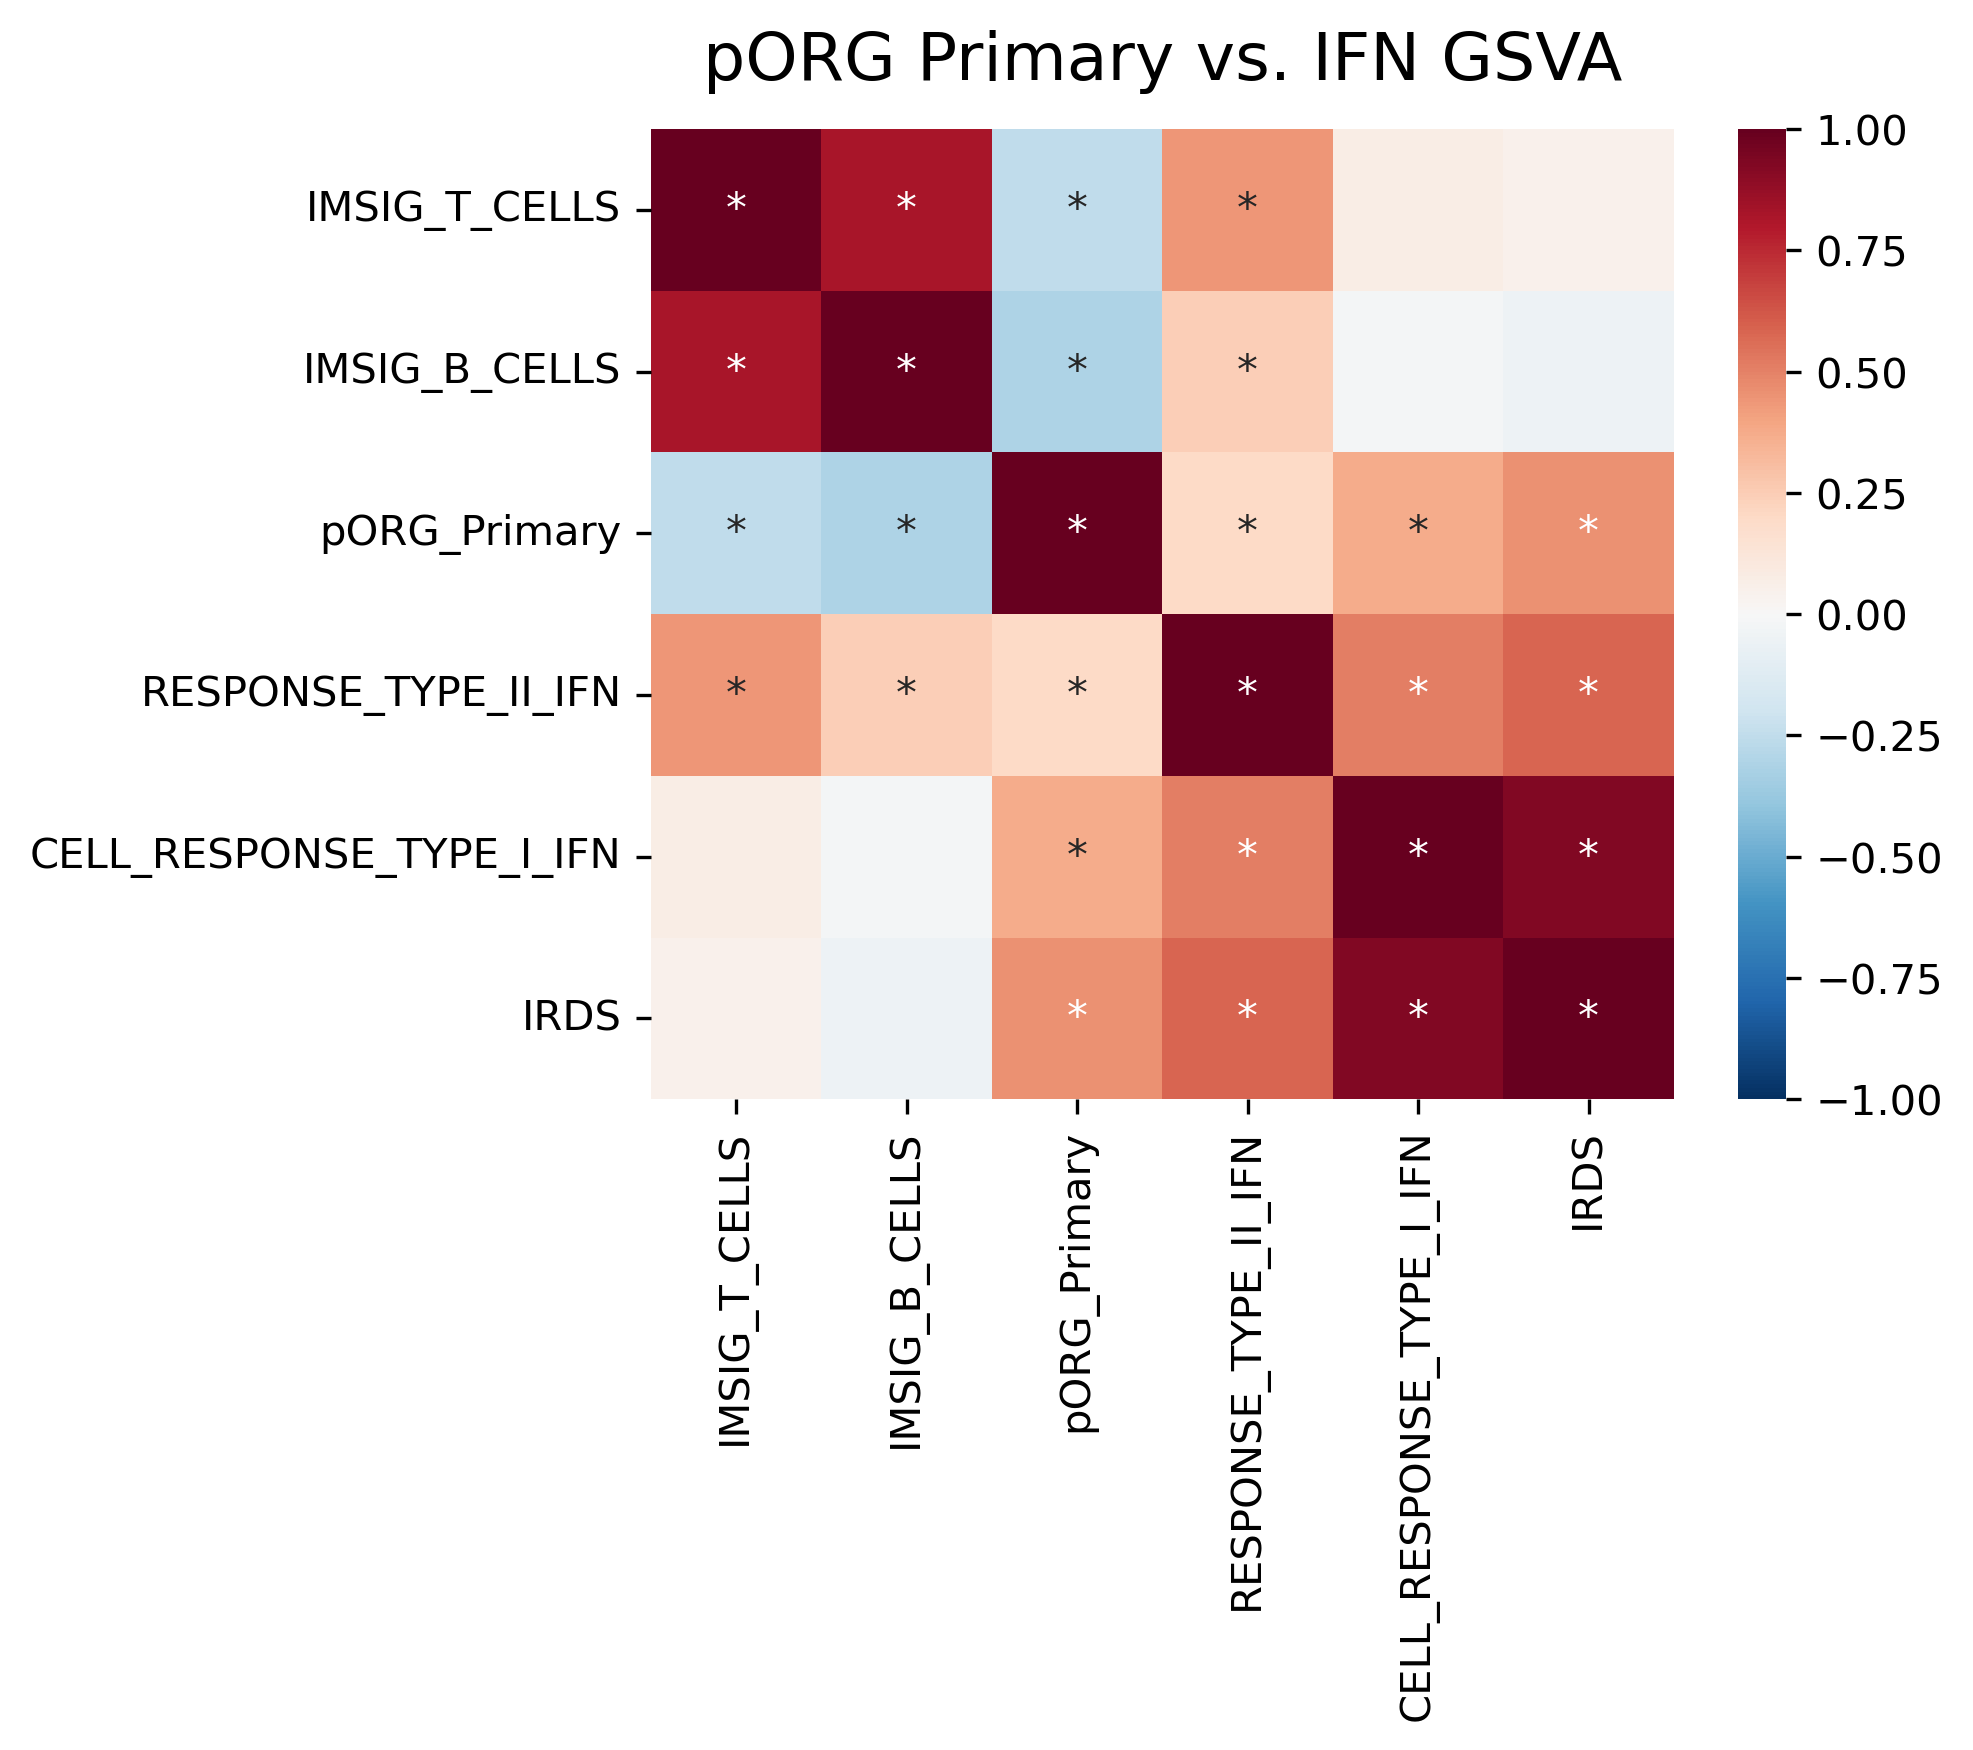

In [63]:
#'''
d_correlate = {'IFN GSVA':(df_plot,ls_gsva_ifn),
              'MHCII':(df_plot,ls_test+ls_gsva_ifn),
               'GSVA/Gene Expression':(df_plot,ls_hallmark_select+ls_krt_select),
               'Hallmarks':(df_gsva,ls_hallmark_select),
               'Immune Gene Signatures':(df_gsva,ls_gsva),
               'Gene Expression':(df_gene,ls_krt),
               'Deconvolution':(df_deconv,ls_deconv)}
d_rename = {'neutrophil_degranulation':'GO_NEUTROPHIL_DEGRANULATION',
            'response to type II interferon':'RESPONSE_TYPE_II_IFN',
            'cellular response to type I interferon':'CELL_RESPONSE_TYPE_I_IFN',
            'T cells':'IMSIG_T_CELLS','B cells':"IMSIG_B_CELLS"}
for s_merge, tu in d_correlate.items():
    df = tu[0]
    ls_col = tu[1]
    #limit to primary tumors
    #df_plot = df_tcr_pri.loc[df_tcr_pri.Tumor_Type == 'Primary',ls_tcr].merge(df.loc[:,ls_col],left_index=True,right_index=True)
    try:
        df_plot['Age at Diagnosis'] = df_plot.loc[:,'Age at Diagnosis'].astype('float64')
    except:
        pass
    df_all = df.loc[:,(df.dtypes=='float64') & (~df.columns.duplicated())].copy()
    df_all = df_all.loc[:,ls_col + ['pORG_Primary']]
    df_all.rename(d_rename,axis=1,inplace=True)
    dim = (5.5,4.2)
    g = sns.clustermap(df_all.corr())
    plt.close()
    categories_order = df_all.corr().iloc[g.dendrogram_col.reordered_ind,:].index.tolist()
    df_all = df_all.loc[:,categories_order]
    rho = df_all.corr()
    #pval = df_all.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
    pval = df_all.corr(method=lambda x, y: stats.spearmanr(x, y)[1]) - np.eye(*rho.shape)
    p_vals = pval.applymap(lambda x: ''.join(['*' for t in [0.05] if x<=t])) #0.001,0.005,
    fig, ax = plt.subplots(figsize=dim,dpi=300)
    sns.heatmap(df_all.corr(), vmin=-1, vmax=1, annot=p_vals, fmt = '', cmap='RdBu_r',ax=ax,yticklabels=1,xticklabels=1)
    #ax.set_title(f'TCR Metrics vs. {s_merge}', fontdict={'fontsize':16}, pad=12)
    #if len(ls_tcr) == 1:
    ax.set_title(f'pORG Primary vs. {s_merge}', fontdict={'fontsize':16}, pad=12)
    break #'''

## krt tertiles

In [ ]:
# for s_marker in ['KRT19','KRT5']:
#     df_krt = df_surv_all.drop('leiden',axis=1).copy()
#     se_tertile = pd.qcut(df_gene.loc[df_surv_all.index,s_marker].drop_duplicates(),q=[0,.33,.66,1],labels=['low','med','high'])
#     df_krt['leiden'] = df_krt.index.map(se_tertile)
#     df_krt = df_krt.drop_duplicates()
#     util.km_cph(df_krt.dropna())
#     plt.suptitle(f'{s_marker}',y=1)
#     break

In [ ]:
# # KRT19 tertile
# df_all['KRT19_tertile'] = df_all.index.map(df_krt.leiden)
# d_color=dict(zip(['high','med','low'],palette))
# figsize=(15,5.5)
# df_clust_map = df_all.groupby('KRT19_tertile').mean()
# row_colors = df_clust_map.index.astype('str').map(d_color)
# g = sns.clustermap(df_clust_map,xticklabels=1,cmap='viridis',z_score=1,vmin=-1.3,vmax=1.3,
#                   dendrogram_ratio=0.1, cbar_pos=(.04, 0.92, 0.03, 0.10),figsize=figsize,method='complete',
#                    row_colors=row_colors)
                   

In [ ]:
#df_plot.to_csv('results_primaries_KRT19_subtypes.csv')

In [ ]:
#df_surv_all.to_csv('results_primaries_leiden_subtypes.csv')

## DEseq2 <a name="rnadeseq"></a> 

[contents](#contents)

In [ ]:
# df_marker = pd.read_csv('annotation/PanglaoDB_markers_27_Mar_2020.tsv',sep='\t') 
# #pdac data set
# df_marker2 = pd.read_csv('annotation/PAAD_GSE111672_AllDiffGenes_table.tsv',sep='\t')
# df_marker3 = pd.read_csv('annotation/PAAD_CRA001160_AllDiffGenes_table.tsv',sep='\t')

In [ ]:
# ls_neut2= df_marker2[df_marker2.loc[:,'Celltype (major-lineage)']=='Neutrophils'].Gene

In [ ]:
# ls_neut= df_marker.loc[df_marker.loc[:,'cell type']=='Neutrophils','official gene symbol']

In [ ]:
# df_results[(df_results.padj<0.1)& (df_results.gene_name.isin(ls_neut))].sort_values(by='log2FoldChange')

In [ ]:
# df_results[(df_results.padj<0.1) & (df_results.gene_name.isin(ls_neut2))]

In [ ]:
# df_results[(df_results.padj>0.1) & (df_results.gene_name.isin(ls_neut2))]

In [ ]:
# #neutrophil genes are lower in lung
# ls_gene = ['CXCR1','CXCR2','CXCL1', 'CXCL2', 'CXCL3', 'CXCL5', 'CXCL6', 'CXCL7', 'CXCL8','CCRL2',#neutophils
#            'CCR2','CCL2','CD68','CCL8','CCL7',#macs
#           'CD3E','CD4','CD8A','CCL21','IL2','XCL1',
#            'CCR5','CXCR3','CCR7','CCL5','CCL3','CXCL9','CXCL10','CCL21','CCL19',# Tcell recruitment
#           'CD44','CDH1','KRT19','KRT7','KRT8','KRT5','KRT17'] #epithelial 
# for s_gene in ls_gene:
#     if (df_results.loc[df_results.gene_name == s_gene,'pvalue'] < 0.05).any():
#             print(df_results.loc[df_results.gene_name == s_gene,['pvalue','padj','gene_name','log2FoldChange']])
#             print(df_marker.loc[df_marker.loc[:,'official gene symbol']==s_gene,'cell type'])
    
# ls_gene = df_marker[(df_marker.loc[:,'cell type']=='Neutrophils')&(df_marker.species.str.contains('Hs'))].sort_values(
#     by='ubiquitousness index').loc[:,'official gene symbol'][0:10]
# print('TOP NEUTROPHIL GENES')
# for s_gene in ls_gene:
#     try:
#         if (df_results.loc[df_results.gene_name == s_gene,'pvalue'] < 0.05).any():
#             print(df_results.loc[df_results.gene_name == s_gene,['pvalue','padj','gene_name','log2FoldChange']])
#             print(df_marker.loc[df_marker.loc[:,'official gene symbol']==s_gene,'cell type'])
#     except:
#         print('why')

In [ ]:
# # in lung cohort, lots of genes found in myocytes, endothelial cells, acinar, nerve, pancreatic progenitor cells
# # in liver cohort, epithelial genes
# for s_gene in df_results[df_results.padj<0.05].sort_values(by='log2FoldChange').gene_name:
#     df_gene= df_marker[df_marker.loc[:,'official gene symbol']==s_gene]
#     if len(df_gene) > 0:
#         print(s_gene)
#         print(df_results[df_results.gene_name==s_gene].log2FoldChange.values[0])
#         print(df_gene.loc[:,'cell type'])
#     else:
#         continue#print(f'{s_gene} not found')

In [ ]:
# for s_gene in df_results[df_results.padj<0.05].sort_values(by='log2FoldChange').gene_name:
#     df_gene= df_marker2[df_marker2.loc[:,'Gene']==s_gene]
#     if len(df_gene) > 0:
#         print(s_gene)
#         print(df_results[df_results.gene_name==s_gene].log2FoldChange.values[0])
#         print(df_gene.loc[:,'Celltype (minor-lineage)'])
#     else:
#         continue#print(f'{s_gene} not found')

In [ ]:
# for s_gene in df_results[df_results.padj<0.05].sort_values(by='log2FoldChange').gene_name:
#     df_gene= df_marker3[df_marker3.loc[:,'Gene']==s_gene]
#     if len(df_gene) > 0:
#         print(s_gene)
#         print(df_results[df_results.gene_name==s_gene].log2FoldChange.values[0])
#         print(df_gene.loc[:,'Celltype (minor-lineage)'])
#     else:
#         continue#print(f'{s_gene} not found')

In [ ]:
# df_matrix = pd.read_csv('DESeq2_matrix.csv',index_col=0)
# df_matrix.index = [item.split('.')[0] for item in df_matrix.index]
# df_matrix['Gene'] = df_matrix.index.map(dict(zip(df_gene_names.GENEID,df_gene_names.SYMBOL)))
# df_matrix = df_matrix.set_index('Gene')

In [ ]:
# ls_col = ['CXCR1','CXCR2','CXCL1', 'CXCL2', #also in monocyte
#           'S100A12', 'S100A9', 'MMP8', 'ARG1','OLFM4','CD274',#immature neutrophils,immunosupressive
#           'CXCL3', 'CXCL5', 'CXCL6',  'CXCL8','CCRL2','CEACAM8','MPO','ITGAM','CD33',#neutophils 'CXCL7',
#            'CCR2','CCL2','CD68','CD163',#'CCL8','CCL7',#macs
#           'CD3E','CD4','CD8A'],#'CCL21','IL2','XCL1','CCR5','CXCR3','CCR7','CCL5','CCL3','CXCL9','CXCL10','CCL21','CCL19'] # Tcell recruitment


In [ ]:
# df_t = df_matrix.loc[ls_col].T
# df_t.index.name = 'OPTR.Specimen.ID'
# df_plot = df_cat.merge(df_t,left_index=True,right_index=True)

In [ ]:
# %matplotlib inline
# for s_col in ls_col[0]:
#     statistic, pvalue = scipy.stats.pearsonr(x=df_plot.loc[~df_plot.pORG_Primary.isna(),'pORG_Primary'],
#                                           y=df_plot.loc[~df_plot.pORG_Primary.isna(),s_col])
#     if pvalue < 0.05:
#         print(s_col)
#         fig, ax = plt.subplots()
#         sns.regplot(data=df_plot[~df_plot.pORG_Primary.isna()],x='pORG_Primary',y=s_col)
#         ax.set_title(f'{s_col} r={statistic:.2} p={pvalue:.2}')                                      
#     #break

In [ ]:
# ls_compare = ['CD3E','CD4','CD68','CD8A'] #'CD3D','CD3G','GZMB','MS4A1'
# df_filter = df_filter.set_index('SpecimenID')
# df_compare = df_plot[~df_plot.pORG_Primary.isna()].loc[:,ls_compare].merge(df_filter.loc[:,ls_compare],left_index=True,
#                         right_index=True, suffixes=('','_c'))

In [ ]:
# for s_col in ls_compare:
#     statistic, pvalue = scipy.stats.pearsonr(x=df_compare.loc[:,s_col],
#                                           y=df_compare.loc[:,f'{s_col}_c'])
#     if pvalue < 0.1:
#         print(s_col)
#         fig, ax = plt.subplots()
#         sns.regplot(data=df_compare,x=s_col,y=f'{s_col}_c')
#         ax.set_title(f'{s_col} r={statistic:.2} p={pvalue:.2}')    

### GSVA <a name="rnagsva"></a> 

[contents](#contents)

In [ ]:
# #
# df_cat = pd.read_csv('20230905_Patient_Metadata_OPTR.csv',index_col=0)
# #df_cat['Survival'] = df_cat.cVitalStatus.replace({'Alive':0,'Dead':1})
# #df_cat['OPTR'] = np.int64(df_cat.OPTR_x)
# print(df_cat.OPTR.dropna().duplicated().any())
# df_cat['OPTR'] = np.int64(df_cat.OPTR)

In [ ]:
# # load new survival

# df_new_surv = pd.read_excel('annotation/cancer_participant_overview_optr_2023-05-04_16-55-18.xlsx')#,dtype=object
# df_surv['Participant ID'] = [item.split('-')[0] for item in df_surv.Old_Pt_ID]
# df_new_surv.loc[:,'Participant ID'] = df_new_surv.loc[:,'Participant ID'].astype(object)
# df_new_surv.loc[:,'OPTR'] = np.int64(df_new_surv.loc[:,'Participant ID'])
# #define rapid recurrence
# for s_dates in df_new_surv.columns[df_new_surv.columns.str.contains("Date")]:
#     df_new_surv[s_dates]= pd.to_datetime(df_new_surv[s_dates],yearfirst=True)
# df_new_surv['Resection_to_Recurrence'] = df_new_surv.loc[:,'First Recurrence Date'] - df_new_surv.loc[:,'Definitive Resection Date'] #

# df_new_surv['Resection_to_Progression']  = df_new_surv.loc[:,'First Progression Date'] - df_new_surv.loc[:,'Definitive Resection Date'] #- 
# b_rr = (df_new_surv['Resection_to_Recurrence'] < pd.Timedelta("180 days")) & (df_new_surv.loc[:,'Type of First Recurrence']=='Distant recurrence invasive tumor,liver')
# print(b_rr.value_counts())

# b_ls = (df_new_surv['Resection_to_Recurrence'] > pd.Timedelta("548 days"))#"730 days"
# print(b_ls.value_counts())
# df_new_surv.loc[b_rr,'RecurrenceState'] = 'rapid'
# df_new_surv.loc[b_ls,'RecurrenceState'] = 'long-term'
# print(df_new_surv.loc[:,'Participant ID'].duplicated().any())
# df_new_surv.columns

In [ ]:
# df_gsva = pd.read_csv('results/results_GSVA.csv',index_col=0)
# df_gsva.index = [item.replace('X','').replace('.','-') for item in df_gsva.index]
# df_gsva.rename({'neutrophil activation involved in immune response':'neut. act. invol. in imm. resp.',
#                'T cell activation involved in immune response':'T cell act. invol. in imm. resp.'},axis=1,inplace=True)
# df_gsva['OPTR'] = [int(item.split('-')[0]) for item in df_gsva.index]
# df_gsva.OPTR.duplicated().any()

In [ ]:
# ls_col = ['pORG_Primary','pSUB_Primary','RecurrenceState','PurIST_Subtype','LiverVsLungOnly',
#                        'cDays_from_Diagnosis_to_FU','cDays_from_Resection_to_Recurrence','Survival',
#                        'HR_DDR_Alterations','BRCA_Alterations']
# ls_col = [ #'Days from Diagnosis to FU',
#           'OPTR',
# #  'Days from Resection to Recurrence',
# #  'Days from Resection to FU',
# #  'Days from Earliest Recur to FU','Survival',
#      'PurIST_Primary'
#    ]
# df_plot = df_cat.loc[:,ls_col].merge(df_gsva,on='OPTR')

In [ ]:
# #df_plot = df_cat.loc[:,ls_col].merge(df_new_surv.loc[:,['RecurrenceState','OPTR']],on='OPTR')
# df_plot = df_plot.merge(df_new_surv.loc[:,['RecurrenceState','OPTR']],on='OPTR')
# df_plot = df_plot.replace({'NoData':np.nan})

In [ ]:

# df_plot =df_plot.dropna()
# df_plot

In [ ]:
# ls  = df_plot[df_plot.RecurrenceState.notna()].OPTR
# print(len(ls))
# df_cat[(df_cat.OPTR.isin(ls)) & (df_cat.PurIST_Primary_T2.notna())].OPTR

In [ ]:
# df_plot.loc[df_plot.OPTR==4806]
# df_plot.RecurrenceState.value_counts()

In [ ]:
# # select col
# ls_gsva = df_gsva.columns.tolist() + ['PurIST_Primary']
# ls_gsva =  ['HALLMARK_MYOGENESIS']#['PurIST_Met']#['HALLMARK_MYC_TARGETS_V1','HALLMARK_MYC_TARGETS_V2']
# alpha = 1.1
# savedir = f'{codedir}/{s_date}'
# s_time = 'cDays_from_Diagnosis_to_FU'
# s_censor = 'Survival' #'cVitalStatus'
# for s_marker in ls_gsva: #df_gsva.columns[-30::]:#['response to type II interferon','type II interferon-mediated signaling pathway']:#[-28::]:#df_gsva.columns[-12:-10]: #
#     for s_group in ['RecurrenceState']:#'RecurrenceState','PurIST_Subtype',,'LiverVsLungOnly','RecurrenceState','HR_DDR_Alterations','BRCA_Alterations'
#         try:
#             s_high = df_plot.loc[:,s_group].dropna().unique()[0]
#             s_low = df_plot.loc[:,s_group].dropna().unique()[1]
#         except:
#             print(f'{s_marker} error')
#             continue
#         n_high = sum(df_plot.loc[:,s_group]==s_high)
#         n_low = sum(df_plot.loc[:,s_group]==s_low)
#         statistic,pvalue = stats.ttest_ind(df_plot.loc[df_plot.loc[:,s_group]==s_high,s_marker],
#                                            df_plot.loc[df_plot.loc[:,s_group]==s_low,s_marker])
#         #statistic,pvalue = stats.mannwhitneyu(df_plot.loc[df_plot.loc[:,s_group]==s_high,s_marker],
#         #                                       df_plot.loc[df_plot.loc[:,s_group]==s_low,s_marker])
#         if pvalue <= alpha:
#             fig, ax = plt.subplots(figsize=(3.3,3),dpi=300)
#             sns.boxplot(data=df_plot,x=s_group,y=s_marker,showfliers=False,ax=ax,order=['long-term','rapid']) #,palette=['mediumpurple','deepskyblue']
#             sns.stripplot(data=df_plot,x=s_group,y=s_marker,ax=ax,palette='dark',order=['long-term','rapid'])#,palette=['indigo','mediumblue']
#             ax.set_ylim(ax.get_ylim()[0],ax.get_ylim()[1])
#             #plt_sig(df_test,ax,10)
#             ax.set_title(f'{s_group} versus\n {s_marker}\np={pvalue:.4f} (n={n_low}, {n_high})')
#             ax.set_ylabel(f'GSVA Score')
#             plt.tight_layout()
#             fig.savefig(f'{s_date}/boxplot_GSVA_{s_marker.replace(" ","_")}_versus_{s_group}.png')
#             break
            
# #         break
#     #break
#     #s_plat = ''
#     #s_subtype = f''
#     #s_cell = 'GSVA'
#     #for cutp in [.5,0.33,0.66]: #,0.33
#     #    df_km_p = single_km(df_plot,s_cell,s_subtype,s_plat,s_marker,savedir,alpha,cutp,s_time,s_censor)



In [ ]:
# %matplotlib inline
# for s_col in ls_gsva:#df_gsva.columns[-38::]:
#     statistic, pvalue = scipy.stats.pearsonr(x=df_plot.loc[~df_plot.pORG_Primary.isna(),'pORG_Primary'],
#                                           y=df_plot.loc[~df_plot.pORG_Primary.isna(),s_col])
#     if pvalue < 0.1:
#         print(s_col)
#         fig, ax = plt.subplots()
#         sns.regplot(data=df_plot[~df_plot.pORG_Primary.isna()],x='pORG_Primary',y=s_col)
#         ax.set_title(f'{s_col} r={statistic:.2} p={pvalue:.2}')     

In [ ]:
# df_cat['Survival'] = df_cat.cVitalStatus.replace({'Alive':0,'Dead':1})
# alpha = 0.05
# s_plat = ''
# s_subtype = f''
# s_cell = 'GSVA'
# for s_col in ls_gsva:#df_gsva.columns:
#     #s_col = 'HALLMARK_MYC_TARGETS_V1'
#     statistic, pvalue = scipy.stats.pearsonr(x=df_plot.loc[~df_plot.pORG_Primary.isna(),'pORG_Primary'],
#                                           y=df_plot.loc[~df_plot.pORG_Primary.isna(),s_col])
#     if pvalue < 0.01:
#         #print(s_col)
#         fig, ax = plt.subplots()
#         sns.regplot(data=df_plot[~df_plot.pORG_Primary.isna()],x='pORG_Primary',y=s_col)
#         ax.set_title(f'{s_col} r={statistic:.2} p={pvalue:.2}')     
#         s_plat = ''
#         s_subtype = f''
#         s_cell = 'GSVA'
#     for cutp in [.5,0.33,0.66,.3,.6]: #,0.33
#         df_km_p = util.single_km(df_plot,s_cell,s_subtype,s_plat,s_col,savedir,alpha,cutp,s_time,s_censor)
#     #break
#     #for cutp in [.5,0.33,0.66]: #,0.33
#     #    df_km_p = single_km(df_plot,s_cell,s_subtype,s_plat,s_col,savedir,alpha,cutp,
#     #                        s_time='cDays_from_Resection_to_Recurrence',s_censor=s_censor)
#     #break

In [ ]:
# df_all = df_plot.loc[:,df_plot.dtypes=='float64']
# dim = (20,20)
# g = sns.clustermap(df_all.corr())
# plt.close()
# categories_order = df_all.corr().iloc[g.dendrogram_col.reordered_ind,:].index.tolist()
# df_all = df_all.loc[:,categories_order]
# rho = df_all.corr()
# pval = df_all.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
# p_vals = pval.applymap(lambda x: ''.join(['*' for t in [0.05] if x<=t])) #0.001,0.005,
# fig, ax = plt.subplots(figsize=dim,dpi=300)
# sns.heatmap(df_all.corr(), vmin=-1, vmax=1, annot=p_vals, fmt = '', cmap='RdBu_r',ax=ax,yticklabels=1,xticklabels=1)
# #ax.set_title(f'Fraction Cell Type in {s_compartment} Correlation', fontdict={'fontsize':16}, pad=12)

### TCRseq analysis <a name="tcr"></a> 



[contents](#contents)

In [36]:
#load data
#df_cat = pd.read_csv('annotation/Patient_metadata_2023.csv',index_col=0)
df_cat = pd.read_excel('Supplemental_Data/Supplemental_Dataset_1.xlsx',sheet_name=0,
                          index_col=0)

In [37]:
ls_tcr = ['Tumor_RearrangementDetails_05-25-2023_5-19-54_PM.tsv',
          'Blood1_RearrangementDetails_05-25-2023_5-38-47_PM.tsv',
          'Blood2_RearrangementDetails_05-25-2023_5-52-58_PM.tsv',
         'Mets_RearrangementDetails_05-25-2023_5-59-08_PM.tsv']
df_tcr_all = pd.DataFrame()
for s_tcr in ls_tcr:
    print(s_tcr)
    df_tcr = pd.read_csv(f'../TCR/{s_tcr}',sep='\t')#,index_col=0
    df_tcr_all = pd.concat([df_tcr_all,df_tcr])
    #break

Tumor_RearrangementDetails_05-25-2023_5-19-54_PM.tsv
Blood1_RearrangementDetails_05-25-2023_5-38-47_PM.tsv
Blood2_RearrangementDetails_05-25-2023_5-52-58_PM.tsv
Mets_RearrangementDetails_05-25-2023_5-59-08_PM.tsv


In [38]:
df_tcr_all['Public_Patient_ID'] = ['ST-' + item.split('-')[1] for item in df_tcr_all.sample_name]
print(df_tcr_all.sample_name.nunique())
289 + 174 + 42

505


505

In [39]:
#look at total productive templates in the tumor and blood
df_tcr_all[df_tcr_all.sample_name.str.contains('-B')].head()

,sample_name,productive_frequency,templates,amino_acid,rearrangement,v_resolved,d_resolved,j_resolved,Public_Patient_ID
0,ST-00007216-B,0.858549,659405,CASSFGQGNYGYTF,CTGGAGTCGCCCAGCCCCAACCAGACCTCTCTGTACTTCTGTGCCA...,TCRBV27-01*01,TCRBD01-01*01,TCRBJ01-02*01,ST-00007216
1,ST-00016998-B,0.653992,55501,CASSQDFRTGLREAFF,GCCCTGCAGCCAGAAGACTCAGCCCTGTATCTCTGCGCCAGCAGCC...,TCRBV04-01*01,unknown,TCRBJ01-01*01,ST-00016998
2,ST-00019607-B,0.585614,22193,CASSLGGSANTEAFF,CAGCGCACAGAGCAGGGGGACTCGGCCATGTATCTCTGTGCCAGCA...,TCRBV07-09*01,TCRBD01-01*01,TCRBJ01-01*01,ST-00019607
3,ST-00020128-B,0.380833,21228,CASSLEGADNEQYF,GTGAACGCCTTGGAGCTGGAGGACTCGGCCCTGTATCTCTGTGCCA...,TCRBV05-08*01,unknown,TCRBJ02-07*01,ST-00020128
4,ST-00022635-B,0.363202,29123,CASSQNGGGNYGYTF,CACACCCTGCAGCCAGAAGACTCGGCCCTGTATCTCTGCGCCAGCA...,TCRBV04-03*01,TCRBD01-01*01,TCRBJ01-02*01,ST-00022635


## Calculate public and private clones

In [ ]:
# #We defined a TCR sequence as a unique combination of V-CDR3-(amino acid sequence)-J. 
# #Any TCR sequence found in only 1 donor was “private” and sequences found in more than 1 donor were “public.”
# se_public_all = df_tcr_all.groupby('amino_acid').Public_Patient_ID.nunique()
# se_public = se_public_all[se_public_all>1] #14% of sequnces are public

In [ ]:
# #percent public

# df_distinct = pd.DataFrame()
# ls_un = df_tcr_all[~df_tcr_all.sample_name.str.contains('-B')].sample_name.unique()
# for s_sample in ls_un:
#     print(s_sample)
#     df_sample = df_tcr_all.loc[(df_tcr_all.sample_name==s_sample) | (df_tcr_all.sample_name==s_sample.replace('-T','-B').replace('-M','-B').replace('-Ma','-B').replace('-Mb','-B'))]#.values
#     df_tumor = df_tcr_all.loc[(df_tcr_all.sample_name==s_sample)]
#     df_blood = df_tcr_all.loc[(df_tcr_all.Public_Patient_ID==df_sample.Public_Patient_ID.iloc[0]) & (df_tcr_all.sample_name.str.contains('-B'))]
#     i_distinct = sum(df_tumor.amino_acid.isin(se_public.index))
#     i_distinct_bld = sum(df_blood.amino_acid.isin(se_public.index))
#     df_distinct.loc[s_sample,'Number Tumor Public Clones'] = i_distinct
#     df_distinct.loc[s_sample,'Number Blood Public Clones'] = i_distinct_bld
#     try:
#         df_distinct.loc[s_sample,'Fraction Tumor Public Clones'] = i_distinct/df_tumor.amino_acid.nunique()
#     except: 
#         df_distinct.loc[s_sample,'Fraction Tumor Public Clones'] = np.nan
#     try:
#         df_distinct.loc[s_sample,'Fraction Blood Public Clones'] = i_distinct_bld/df_blood.amino_acid.nunique()
#     except: 
#         df_distinct.loc[s_sample,'Fraction Blood Public Clones'] = np.nan
#     #print(i_distinct_bld/df_blood.amino_acid.nunique())
    

# df_distinct.to_csv(f'Liver_Lung_PDAC/TCR_Fraction_Public_Clones.csv')


In [ ]:
# #percent public (blood)

# df_distinct = pd.DataFrame()
# ls_un = df_tcr_all[df_tcr_all.sample_name.str.contains('-B')].sample_name.unique()
# print(len(ls_un))
# for s_sample in ls_un:
#     print(s_sample)
#     df_sample = df_tcr_all.loc[(df_tcr_all.sample_name==s_sample) | (df_tcr_all.sample_name==s_sample.replace('-T','-B').replace('-M','-B').replace('-Ma','-B').replace('-Mb','-B'))]#.values
#     df_blood = df_tcr_all.loc[(df_tcr_all.Public_Patient_ID==df_sample.Public_Patient_ID.iloc[0]) & (df_tcr_all.sample_name.str.contains('-B'))]
#     i_distinct_bld = sum(df_blood.amino_acid.isin(se_public.index))
#     df_distinct.loc[s_sample,'Number Blood Public Clones'] = i_distinct_bld
#     try:
#         df_distinct.loc[s_sample,'Fraction Blood Public Clones'] = i_distinct_bld/df_blood.amino_acid.nunique()
#     except: 
#         df_distinct.loc[s_sample,'Fraction Blood Public Clones'] = np.nan
    

# df_distinct.to_csv(f'Liver_Lung_PDAC/TCR_Fraction_Public_Clones_Blood.csv')

## calculate shared/ clonal sequences

For shared, clonal sequences within cohorts, the top 50 rearrangements (by frequency in each sample) were 
compiled for all samples, and the Immunoseq Sequence Search Tool was used to identify all samples in the
cohort that contained any of those CDR3b sequences at any frequency. Only the CDR3b amino acid sequences 
found in at least 25% of samples in the cohort were considered shared, clonal sequences. 

In [40]:
df_tcr_all.sample_name.unique()

array(['ST-00017310-T', 'ST-00015136-T', 'ST-00020236-T', 'ST-00013374-T',
       'ST-00017227-T', 'ST-00007216-T', 'ST-00010984-T', 'ST-00021412-T',
       'ST-00007165-T', 'ST-00014550-T', 'ST-00016499-T', 'ST-00018963-T',
       'ST-00014490-T', 'ST-00020102-T', 'ST-00019043-T', 'ST-00013158-T',
       'ST-00020077-T', 'ST-00018955-T', 'ST-00011357-T', 'ST-00021832-T',
       'ST-00020098-T', 'ST-00018988-T', 'ST-00007257-T', 'ST-00017440-T',
       'ST-00018724-T', 'ST-00013861-T', 'ST-00013253-T', 'ST-00019056-T',
       'ST-00017074-T', 'ST-00007296-T', 'ST-00020482-T', 'ST-00021190-T',
       'ST-00012327-T', 'ST-00022177-T', 'ST-00020291-T', 'ST-00018821-T',
       'ST-00016742-T', 'ST-00007178-T', 'ST-00020640-T', 'ST-00007303-T',
       'ST-00018257-T', 'ST-00016968-T', 'ST-00005536-T', 'ST-00007267-T',
       'ST-00020225-T', 'ST-00020258-T', 'ST-00016858-T', 'ST-00007223-T',
       'ST-00012818-T', 'ST-00007239-T', 'ST-00017985-T', 'ST-00019458-T',
       'ST-00020936-T', '

In [ ]:
# # For shared, clonal sequences within cohorts, the top 50 rearrangements (by frequency in each sample) were 
# # compiled for all samples, and the Immunoseq Sequence Search Tool was used to identify all samples in the
# # cohort that contained any of those CDR3b sequences at any frequency. Only the CDR3b amino acid sequences 
# # found in at least 25% of samples in the cohort were considered shared, clonal sequences. 
# ls_un = df_tcr_all.sample_name.unique()
# d_top50 = {}
# print(len(ls_un))
# for idx, s_sample in enumerate(ls_un):
#     print(f'{idx} {s_sample}')
#     df_sample = df_tcr_all.loc[(df_tcr_all.sample_name==s_sample)]
#     es_sample = set(df_sample.sort_values(by='productive_frequency',ascending=False)[0:50].amino_acid)
#     d_top50.update({s_sample:es_sample})
    
# #save
# d_top50_ls = {}
# for key, item in d_top50.items():
#     d_top50_ls.update({key:list(item)})

# import json
# with open("TCRtop50.json", "w") as outfile:
#     json.dump(d_top50_ls, outfile)

In [ ]:
# #need to figure out which are in 25% of cohort... samples ... tumor .. blood
# #load...
# import json
 
# # Opening JSON file
# with open('TCRtop50.json', 'r') as openfile:
 
#     # Reading from json file
#     d_top50 = json.load(openfile)

# es_top50 = set()
# for key, item in d_top50.items():
#     es_top50 = es_top50.union(item)

In [ ]:
# # add cohorts
# df6 = pd.read_excel('./MethodsAndReferencesSupplementalData/SupplementalDataset6.xlsx',sheet_name=None)
# for s_sheet in ['Tumor Samples','Blood Samples']:
#     df6[s_sheet].loc[df6[s_sheet].loc[:,'Lung Met Present in Patient'] == 'YES','Cohort'] = 'Lung'
#     df6[s_sheet].loc[df6[s_sheet].loc[:,'Liver Met Present in Patient'] == 'YES','Cohort'] = 'Liver'
#     print(df6[s_sheet]['Cohort'].value_counts())
#     d_cohort = dict(zip(df6[s_sheet].loc[:,'Patient ID'],df6[s_sheet].loc[:,'Cohort']))
#     if s_sheet == 'Blood Samples':
#         b_sample = df_tcr_all.sample_name.str.contains('-B')
#     else:
#         b_sample = ~df_tcr_all.sample_name.str.contains('-B')
#     df_tcr_all.loc[b_sample,'Cohort'] = df_tcr_all.loc[b_sample].Public_Patient_ID.map(d_cohort)
#     #break

# #tumor
# df_tcr_all.loc[~df_tcr_all.sample_name.str.contains('-B'),'Site'] = 'Tumor'
# #blood
# df_tcr_all.loc[df_tcr_all.sample_name.str.contains('-B'),'Site'] = 'Blood'
# df_tcr_all['CohortSite'] = df_tcr_all.Cohort + '.' + df_tcr_all.Site 

In [ ]:
# d_shared_clonal = {}
# ls_percent = [0.05,0.1,0.25]
# ls_group = ['Cohort','Site','CohortSite']
# for i_percent in ls_percent:
#     for s_group in ls_group:
#         for s_cohort in df_tcr_all.loc[:,s_group].dropna().unique():
#             print(s_cohort)
#             df_cohort = df_tcr_all[df_tcr_all.loc[:,s_group]==s_cohort]
#             df_test = df_cohort[df_cohort.amino_acid.isin(es_top50)]
#             es_shared = df_test.groupby('amino_acid').Public_Patient_ID.nunique().sort_values(ascending=False)
#             i_thresh = df_cohort.Public_Patient_ID.nunique()*i_percent
#             ls_shared = es_shared[es_shared>i_thresh].index.tolist()
#             s_label = f'{s_group}_{s_cohort}_{i_percent}'
#             d_shared_clonal.update({s_label:ls_shared})


In [ ]:
# d_shared_clonal.keys()
# import json
# with open("TCR_shared_clonal.json", "w") as outfile:
#     json.dump(d_shared_clonal, outfile)
    
# # Opening JSON file
# with open('TCR_shared_clonal.json', 'r') as openfile:
 
#     # Reading from json file
#     json_object = json.load(openfile)

In [ ]:
# df_distinct = pd.DataFrame()
# for idx, s_sample in enumerate(ls_un):
#     print(f'{idx} {s_sample}')
#     df_sample = df_tcr_all.loc[(df_tcr_all.sample_name==s_sample)]
#     i_unique = df_sample[df_sample.amino_acid.isin(es_top50)].amino_acid.nunique()
#     i_total = df_sample.amino_acid.nunique()
#     df_distinct.loc[s_sample,'Number_Top_50'] = i_unique
#     df_distinct.loc[s_sample,'Total_Unique_TCRs'] = i_total
#     for key, item in d_shared_clonal.items():
#         i_unique = df_sample[df_sample.amino_acid.isin(item)].amino_acid.nunique()
#         df_distinct.loc[s_sample,f'{key}_nunique'] = i_unique
#         #break
#     #break
# df_distinct.to_csv(f'Liver_Lung_PDAC/TCR_Shared_Clonal_by_Cohort.csv')

In [ ]:
# df_distinct = pd.DataFrame()
# for idx, s_sample in enumerate(ls_un):
#     print(f'{idx} {s_sample}')
#     df_sample = df_tcr_all.loc[(df_tcr_all.sample_name==s_sample)]
#     i_unique = df_sample[df_sample.amino_acid.isin(es_top50)].amino_acid.nunique()
#     i_total = df_sample.amino_acid.nunique()
#     df_distinct.loc[s_sample,'Number_Top_50'] = i_unique
#     df_distinct.loc[s_sample,'Total_Unique_TCRs'] = i_total
#     for key, item in d_shared_clonal.items():
#         i_unique = df_sample[df_sample.amino_acid.isin(item)].amino_acid.nunique()
#         df_distinct.loc[s_sample,f'{key}_nunique'] = i_unique
#         #break
#     #break
# df_distinct.to_csv(f'Liver_Lung_PDAC/TCR_Shared_Clonal_by_Cohort.csv')

In [ ]:
# #use jasons clones
# ls_un = df_tcr_all.sample_name.unique()
# for s_cohort in df6['Shared, Clonal Seqs'].Cohort.unique():
#     print(s_cohort)
#     es_top50 = set(df6['Shared, Clonal Seqs'][df6['Shared, Clonal Seqs'].Cohort==s_cohort].loc[:,'TCRB CDR3 Amino Acid Sequence'])
#     df_distinct = pd.DataFrame()
#     for idx, s_sample in enumerate(ls_un):
#         print(f'{idx} {s_sample}')
#         df_sample = df_tcr_all.loc[(df_tcr_all.sample_name==s_sample)]
#         i_unique = df_sample[df_sample.amino_acid.isin(es_top50)].amino_acid.nunique()
#         i_total = df_sample.amino_acid.nunique()
#         df_distinct.loc[s_sample,'Number_Shared_Clonal'] = i_unique
#         df_distinct.loc[s_sample,'Total_Unique_TCRs'] = i_total
# #         for key, item in d_shared_clonal.items():
# #             i_unique = df_sample[df_sample.amino_acid.isin(item)].amino_acid.nunique()
# #             df_distinct.loc[s_sample,f'{key}_nunique'] = i_unique
# #             break
#         #break
#     df_distinct.to_csv(f'Liver_Lung_PDAC/TCR_Shared_Clonal_by_{s_cohort.replace("/",".")}.csv')

In [ ]:
# #look at productive freq
# df_distinct = pd.DataFrame(index=ls_un)
# for s_seq in df6['Shared, Clonal Seqs'].loc[:,'TCRB CDR3 Amino Acid Sequence'].unique():
#     se_seq = df_tcr_all[df_tcr_all.amino_acid==(s_seq)].groupby('sample_name').productive_frequency.sum()
#     df_distinct[s_seq] = df_distinct.index.map(se_seq).fillna(0)
# df_distinct.to_csv(f'Liver_Lung_PDAC/TCR_Shared_Clonal_Productive_Freq.csv')
# df_distinct.mean()


In [ ]:
# # Opening JSON file
# with open('TCR_shared_clonal.json', 'r') as openfile:
#     # Reading from json file
#     json_object = json.load(openfile)

In [ ]:
# for s_key, ls_seq in json_object.items():
#     print(s_key)
#     df_distinct = pd.DataFrame(index=ls_un)
#     for s_seq in ls_seq:
#         se_seq = df_tcr_all[df_tcr_all.amino_acid==(s_seq)].groupby('sample_name').productive_frequency.sum()
#         df_distinct[s_seq] = df_distinct.index.map(se_seq).fillna(0)
#     df_distinct.to_csv(f'Liver_Lung_PDAC/TCR_Shared_Clonal_{s_key}_Productive_Freq.csv')

In [ ]:
# show rosie what the data look like
# df_test = df_tcr_all[df_tcr_all.sample_name=='ST-00017310-T']
# df_test.amino_acid.nunique()
# df_test.rearrangement.nunique()

## Shared, Clonal Plots
For shared, clonal sequences within cohorts, the top 50 rearrangements (by frequency in each
sample) were compiled for all samples, and the Immunoseq Sequence Search Tool was used to
identify all samples in the cohort that contained any of those CDR3 sequences at any frequency.
Only the CDR3 amino sequences found in at least 25% of samples in the cohort were considered
shared, clonal sequences.


We found similar numbers of these shared, clonal
CDR3β sequences in liver-cohort tumors (N=21) as in lung-cohort tumors (N=24); in contrast, we
found many more shared, clonal CDR3β sequences among blood samples from patients in the
liver cohort (N=174) than from patients in the lung cohort (N=41, Figure 6B). 
**how is this normalized?**


We examined the frequencies of the shared, clonal responses and
found that in lung-cohort tumors they existed at higher frequencies than in liver-cohort tumors
(Figure 6C), in contrast to what we found for responses to putative mutant KRAS-specific tumor-
initiating epitopes. These results suggest that liver-cohort tumors may promote clonal responses
against persistent neoepitopes (Figure 6A), whereas lung-cohort tumors may be more likely to
develop shared, clonal responses against new (though uncharacterized) tumor antigens



In [ ]:
# def annotated_stripplot(plotting,ls_groups,label):
#     fig, ax = plt.subplots(figsize=(1.3*len(ls_groups),3.2),dpi=300)
#     sns.stripplot(**plotting,ax=ax,alpha=0.8,label=label)
#     sns.boxplot(**plotting,ax=ax,
#                        whiskerprops={'visible': False},showcaps=False,
#                        #meanline=True,showmeans=True,medianprops={'visible': False},
#                        medianprops={'color': 'k', 'ls': '-', 'lw': 1},#meanprops
#                 showfliers=False,showbox=False)
#     pairs = [item for item in itertools.combinations(ls_groups,2)]
#     annot = Annotator(ax,pairs,**plotting)
#     annot.configure(test='t-test_ind',comparisons_correction="fdr_bh",text_format='star', verbose=False)
#     ax, test_results = annot.apply_test().annotate()
#     return(fig,ax,test_results)
# def annotated_stripplot2(plotting,ls_groups,label):
#     fig, ax = plt.subplots(figsize=(1.3*len(ls_groups),3.2),dpi=300)
#     sns.stripplot(**plotting,ax=ax,alpha=0.8,label=label)
#     sns.boxplot(**plotting,ax=ax,
#                        whiskerprops={'visible': False},showcaps=False,
#                        #meanline=True,showmeans=True,medianprops={'visible': False},
#                        medianprops={'color': 'k', 'ls': '-', 'lw': 1},#meanprops
#                 showfliers=False,showbox=False)
#     pairs = [item for item in itertools.combinations(ls_groups,2)]
#     annot = Annotator(ax,pairs,**plotting)
#     annot.configure(test='test_ind',alternative='greater',comparisons_correction="fdr_bh",text_format='star', verbose=False)#'Mann-Whitney'
#     ax, test_results = annot.apply_test().annotate()
#     return(fig,ax,test_results)

In [ ]:
#load data
df_shared_je = pd.read_csv(f'TCR/TCR_Shared_Clonal_by_Cohort.csv',index_col=0)

#add the patient ID 

df_shared_je['Public_Patient_ID'] = ['ST-' + item.split('-')[1] for item in df_shared_je.index]

#load up supplemental data 6: shared clonal
df6 = pd.read_excel('../MethodsAndReferencesSupplementalData/SupplementalDataset6.xlsx',sheet_name=None)
#df6.keys()
es_shared = set(df6['Shared, Clonal Seqs'].loc[:,'TCRB CDR3 Amino Acid Sequence'])
print(len(es_shared))
print(df6['Shared, Clonal Seqs'].Cohort.value_counts())
df_tcr_all['Public_Patient_ID'] = ['ST-' + item.split('-')[1] for item in df_tcr_all.sample_name]

In [ ]:

# #not normalizeb by no. patients
# df_shared = df6['Shared, Clonal Seqs'].groupby('Reported Specific for Infectious Agent').Cohort.value_counts()#.reset_index()
# df_shared.name = 'No.'
# df_shared = df_shared.reset_index(drop=False)
# x=df_shared.Cohort.unique()
# y1=df_shared.loc[df_shared.loc[:,'Reported Specific for Infectious Agent']=='YES','No.']
# y2=df_shared.loc[df_shared.loc[:,'Reported Specific for Infectious Agent']=='NO','No.']
# plt.bar(x, y1, color='r')
# plt.bar(x, y2, bottom=y1, color='k')
# plt.ylabel('No.')
# plt.title('not normalized')
# #plt.close()
# # fig, ax =plt.subplots()
# # sns.barplot(data=df_shared, x='Cohort', y='No.', hue='Reported Specific for Infectious Agent',dodge=True,ax=ax)
# # ax.set_title('not normalized')


In [ ]:
# #add porg quartiles, cohorts, to tcr data
# for s_porg in ['pORG_0.2_All_quartiles','pORG_0.2_Primary_quartiles', 'pORG_0.2_Met_quartiles']:
#     d_score = dict(zip(df_patient.Public_Patient_ID,df_patient.loc[:,s_porg]))
#     df_tcr_all[s_porg] = df_tcr_all.Public_Patient_ID.map(d_score)
# for s_site, d_cohort in dd_cohort.items():
#     df_tcr_all[f'{s_site}_Cohort'] = df_tcr_all.Public_Patient_ID.map(d_cohort)
    
# ls_groups = ['pORG_0.2_All_quartiles','pORG_0.2_Primary_quartiles', 'pORG_0.2_Met_quartiles',
#             'Tumor_Cohort','Blood_Cohort']
# # calculate percentage of samples containing

# for s_cohort in df6['Shared, Clonal Seqs'].Cohort.unique():
#     df = df6['Shared, Clonal Seqs'][df6['Shared, Clonal Seqs'].Cohort==s_cohort]
#     es_seq = set(df.loc[:,'TCRB CDR3 Amino Acid Sequence'])
#     df_tcr_in = df_tcr_all[df_tcr_all.amino_acid.isin(es_seq)]
#     break
# ls_groups = ['pORG_0.2_All_quartiles','pORG_0.2_Primary_quartiles', 'pORG_0.2_Met_quartiles',
#             'Tumor_Cohort','Blood_Cohort']
# for s_group in ls_groups:
#     se_in = df_tcr_in.groupby(s_group).Public_Patient_ID.nunique()
#     break
    
    

In [ ]:
# 6C
x='Cohort'
ls_col = ['Percentage of Samples Containing',
          'Average Frequency',
              #'Sum of Frequencies',
              'Average Frequency\n(among samples with sequence)']
for s_site in ['Tumor','Blood','All']:
    if s_site == 'All':
        df = df6['Shared, Clonal Seqs'].copy()
    else:
        df = df6['Shared, Clonal Seqs'].loc[df6['Shared, Clonal Seqs'].Cohort.str.contains(s_site)].copy()
    df['Average Frequency'] = df['Sum of Frequencies']/df['Number in Cohort']
    df['Percentage of Samples Containing'] = df['Present In']/df['Number in Cohort']
    for s_col in ls_col:
        ls_groups = sorted(df.loc[:,x].dropna().unique())
        print(sorted(df.loc[:,x].dropna().value_counts()))
        plotting = {"data": df,"x": x,"y":s_col,"order":ls_groups}
        fig, ax, test_results = util.annotated_stripplot(plotting,ls_groups,'shared/clonal seq')
        ax.set_title(f'{s_site}')
        ax.legend(bbox_to_anchor=(1,1))
    break
    

In [ ]:
# %matplotlib inline
# # 6B
# #normalized by no patients
# d_counts = {'Liver/Blood':76,'Lung/Blood':16,'Liver/Tumor':59,'Lung/Tumor':16}
# for s_cohort in df_shared.Cohort.unique():
#     df_shared.loc[df_shared.Cohort==s_cohort,'No. per Pt.'] = df_shared.loc[df_shared.Cohort==s_cohort,'No.']/d_counts[s_cohort]
# x=df_shared.Cohort.unique()
# y1=df_shared.loc[df_shared.loc[:,'Reported Specific for Infectious Agent']=='YES','No. per Pt.']
# y2=df_shared.loc[df_shared.loc[:,'Reported Specific for Infectious Agent']=='NO','No. per Pt.']
# plt.bar(x, y1, color='r')
# plt.bar(x, y2, bottom=y1, color='k')
# plt.ylabel('No. per Pt.')
# fig, ax =plt.subplots()
# sns.barplot(data=df_shared, x='Cohort', y='No. per Pt.', hue='Reported Specific for Infectious Agent',dodge=True,ax=ax)

In [ ]:
# for s_site in ['Blood','Tumor']:
#     y= 'No.'#'No. per Pt.'
#     fig, ax = plt.subplots(dpi=300, figsize=(2.2,2))
#     df = df_shared.groupby('Cohort').sum().reset_index()
#     sns.barplot(data=df[df.Cohort.str.contains(s_site)],x='Cohort', y=y,color='k')
#     ax.set_title('Number of Shared/Clonal\nSequences')

# per patient shared/clonal

In [ ]:
# jason's clones
pal_porg_r = ('#E69F00','#56B4E9',)
pal_liv_r = ('#D55E00','#0072B2',)
sns.set_palette(pal_liv_r)
# try - combine the liver and lung
df_sc_pt = pd.read_csv(f'TCR/TCR_Shared_Clonal_Productive_Freq.csv',index_col=0) #jason's
df_patient =  pd.read_csv('annotation/20231012_Patient_Metadata_TCR_Metrics.csv',index_col = 0)
dd_cohort = {}
for s_sheet in ['Tumor Samples','Blood Samples']:
    df6[s_sheet].loc[df6[s_sheet].loc[:,'Lung Met Present in Patient'] == 'YES','Cohort'] = 'Lung'
    df6[s_sheet].loc[df6[s_sheet].loc[:,'Liver Met Present in Patient'] == 'YES','Cohort'] = 'Liver'
    d_cohort = dict(zip(df6[s_sheet].loc[:,'Patient ID'],df6[s_sheet].loc[:,'Cohort']))
    dd_cohort.update({s_sheet.split(' ')[0]:d_cohort})
df_sc = df6['Shared, Clonal Seqs'].iloc[:,0:4].copy().rename({'TCRB CDR3 Amino Acid Sequence':'Sequence'},axis=1)
df_sc = df_sc.merge(df_sc_pt.T.reset_index().rename({'index':'Sequence'},axis=1),on='Sequence',how='left')
ls_cohort = [#'/Blood','/Tumor',
            # 'Liver/Blood', 'Lung/Blood', 
    'Lung/Tumor',
    'Liver/Tumor', 
            ]
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    for s_porg in ['pORG_0.2_Primary_quartiles','pORG_0.2_Met_quartiles','pORG_0.2_All_quartiles']:
        for s_cohort in ls_cohort:
            s_site = s_cohort.split('/')[1]
            if s_site == 'Tumor':
                df = df_sc.loc[df_sc.Cohort.str.contains(s_cohort),~df_sc.columns.str.contains('-B')].T
                df.drop(['Cohort', 'Sequence', 'Reported Specific for Infectious Agent','Sum of Frequencies'],inplace=True)
                if s_porg == 'pORG_0.2_Primary_quartiles':
                    df = df_sc.loc[df_sc.Cohort.str.contains(s_cohort),df_sc.columns.str.contains('-T')].T
                elif s_porg == 'pORG_0.2_Met_quartiles':
                    df = df_sc.loc[df_sc.Cohort.str.contains(s_cohort),df_sc.columns.str.contains('-M')].T
            elif s_site == 'Blood':
                df = df_sc.loc[df_sc.Cohort.str.contains(s_cohort),df_sc.columns.str.contains('-B')].T
            df = df.astype('float64')
            print(set([item.split('-')[-1] for item in df.index]))
            df.index = ['ST-' + item.split('-')[1] for item in df.index]
            df['Shared/Clonal No. per Pt.'] = (df.loc[:,df.dtypes=='float64'] > 0).sum(axis=1)
            df['Shared/Clonal Freq per Pt'] = df.drop('Shared/Clonal No. per Pt.',axis=1).sum(axis=1)
            df['Shared/Clonal No.'] = (df.drop('Shared/Clonal No. per Pt.',axis=1) > 0).sum(axis=1) - 1
            df['Cohort'] = df.index.map(dd_cohort[s_site])
            df['Cohort'] = df['Cohort'].replace({'nan':pd.NA})
            df['Public_Patient_ID'] = ['ST-' + item.split('-')[1] for item in df.index]
            s_primary_met =  s_porg.split('pORG_0.2_')[1].split('_quartiles')[0]
            d_score = dict(zip(df_patient.Public_Patient_ID,df_patient.loc[:,s_porg]))
            df[s_porg] = df.Public_Patient_ID.map(d_score)
            for x in [s_porg,'Cohort',]:
                if x == 'Cohort':
                    sns.set_palette(pal_liv_r)
                else:
                    sns.set_palette(pal_porg_r)
                for s_col in ['Shared/Clonal No. per Pt.','Shared/Clonal Freq per Pt',]:
                    #s_col= #'Shared/Clonal Freq' #'Shared/Clonal No.'#'Shared/Clonal Freq' #,'Shared/Clonal No.'
                    ls_groups = sorted(df.loc[:,x].dropna().unique())
                    print(sorted(df.loc[:,x].dropna().value_counts()))
                    plotting = {"data": df.loc[:,[x,s_col]].dropna(),"x": x,"y":s_col,"order":ls_groups}
                    fig, ax, test_results = util.annotated_stripplot(plotting,ls_groups,'patient')
                    ax.set_title(f"From: {s_cohort.replace('/',' ')}s")
                    ax.set_xlabel(f"{x.replace('_0.2_',' ').replace('_',' ')}")
                    ax.set_ylabel(f"{s_col.replace('/',' ')}")
                    ax.legend(bbox_to_anchor=(1,1)).remove()
                    # if not (np.array([res.data.pvalue for res in test_results]) < 0.1).any():
                    #     plt.close()
                    ax.text(x=-0.1, y=-0.1, s='In:',transform=ax.transAxes)
                    plt.tight_layout()
                    fig.savefig(f"{s_date}/Shared_clonal_from_{s_cohort.replace('/','_')}_in_{x}_{s_col.replace('/','_')}_{s_porg.split('_')[2]}.png",dpi=300)
        #             break
        #             break
        #     break
        # break


In [ ]:
### ## calculate percent containing, jason's clones
# #add porg quartiles, cohorts, to patinet data
# df_sc_pt['Public_Patient_ID'] = ['ST-' + item.split('-')[1] for item in df_sc_pt.index]
# df_sc_seq = df6['Shared, Clonal Seqs'].iloc[:,0:4].copy().rename({'TCRB CDR3 Amino Acid Sequence':'Sequence'},axis=1)

# dd_score = {}
# for s_porg in ['pORG_0.2_All_quartiles','pORG_0.2_Primary_quartiles', 'pORG_0.2_Met_quartiles']:
#     d_score = dict(zip(df_patient.Public_Patient_ID,df_patient.loc[:,s_porg]))
#     dd_score.update({s_porg:d_score})
# for s_sheet in ['Tumor Samples','Blood Samples']:
#     df6[s_sheet].loc[df6[s_sheet].loc[:,'Lung Met Present in Patient'] == 'YES','Cohort'] = 'Lung'
#     df6[s_sheet].loc[df6[s_sheet].loc[:,'Liver Met Present in Patient'] == 'YES','Cohort'] = 'Liver'
#     d_cohort = dict(zip(df6[s_sheet].loc[:,'Patient ID'],df6[s_sheet].loc[:,'Cohort']))
#     dd_score.update({s_sheet.replace(' Samples','_Cohort'):d_cohort})
# for s_key, d_item in dd_score.items():
#     df_sc_pt[s_key] = df_sc_pt.Public_Patient_ID.map(d_item)
    
# for s_index in df_sc_seq.index:
#     s_seq = df_sc_seq.loc[s_index,'Sequence']
#     for s_key in dd_score.keys():
#         df = df_sc_pt.loc[df_sc_pt.loc[:,s_key].notna(),[s_key,s_seq]].copy()
#         df['Contains'] = df[s_seq] > 0
#         try:
#             d_result = dict(df.groupby(s_key).Contains.value_counts(normalize=True).loc[:,True])
#         except:
#             d_result = dict(zip(df.loc[:,s_key].unique(),[0,0]))
#         for column, value in d_result.items():
#             df_sc_seq.loc[s_index, f'{s_key}_{column}'] = value

In [ ]:
# ## plot percent containing, jason's clones
# # does not match figure 6D
# ls_cohort = [
#              #'Liver/Blood', 'Lung/Blood',
#     'Liver/Tumor', 'Lung/Tumor'
#             ]
# ls_col = ['pORG_0.2_All_quartiles_high',
#        'pORG_0.2_All_quartiles_low', 
#           #'Tumor_Cohort_Liver', 'Tumor_Cohort_Lung',
#     # 'pORG_0.2_Primary_quartiles_high',
#     #    'pORG_0.2_Primary_quartiles_low', 'pORG_0.2_Met_quartiles_high',
#       # 'pORG_0.2_Met_quartiles_low'
#          ]
# # ls_col = [
# #        #'Blood_Cohort_Liver', 'Blood_Cohort_Lung'
# #          ]
# for s_cohort in ls_cohort:
#     df = df_sc_seq[df_sc_seq.Cohort==s_cohort]
#     df_plot = df.loc[:,ls_col].unstack().reset_index().rename({'level_0':'Group',
#                                                 0:'Percentage of Samples Containing'},axis=1)
#     plotting = {"data": df_plot,"x": 'Group',
#                 "y":'Percentage of Samples Containing',
#                 "order":ls_col}
#     fig, ax, test_results = annotated_stripplot(plotting,ls_col,'shared/clonal seq')
#     ax.set_title(f'From: {s_cohort}')
#     ax.set_xticklabels([item.replace('_Cohort_',' ').replace('_quartiles_','\n').replace('_0.2_',' ') for item in ls_col])
#     ax.legend(bbox_to_anchor=(1,1))
#     #ax.set_ylim(0,1.3)
#     #break

In [ ]:
# add high and low pORG, need to use less cohort-specicic clones
# use all tumor, all blood instead of liver lung blood and tumor
# nothing is significant ... 

df_patient =  pd.read_csv('annotation/20231012_Patient_Metadata_TCR_Metrics.csv',index_col = 0)
ls_file = [ #'TCR_Shared_Clonal_Site_Blood_0.05_Productive_Freq.csv',
 #'TCR_Shared_Clonal_Site_Blood_0.1_Productive_Freq.csv',
 #'TCR_Shared_Clonal_Site_Blood_0.25_Productive_Freq.csv',
 #'TCR_Shared_Clonal_Site_Tumor_0.05_Productive_Freq.csv',
 #'TCR_Shared_Clonal_Site_Tumor_0.1_Productive_Freq.csv',
 'TCR_Shared_Clonal_Site_Tumor_0.25_Productive_Freq.csv',]
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    for s_file in ls_file:
        df_sc_pt = pd.read_csv(f'TCR/{s_file}',index_col=0) #JE
        df_sc_pt['Public_Patient_ID'] = ['ST-' + item.split('-')[1] for item in df_sc_pt.index]
        df_sc_pt['Shared/Clonal Freq. per Pt.'] = df_sc_pt.loc[:,df_sc_pt.dtypes=='float64'].sum(axis=1)
        df_sc_pt['Shared/Clonal No. per Pt.'] = (df_sc_pt.loc[:,df_sc_pt.dtypes=='float64'] > 0).sum(axis=1) - 1
        s_clonal_site = s_file.split('Clonal_Site_')[1].split('_Productive_Freq')[0].replace('_',' ')
        #add cohorts
        for s_sheet in ['Tumor Samples','Blood Samples']:
            df6[s_sheet].loc[df6[s_sheet].loc[:,'Lung Met Present in Patient'] == 'YES','Cohort'] = 'Lung'
            df6[s_sheet].loc[df6[s_sheet].loc[:,'Liver Met Present in Patient'] == 'YES','Cohort'] = 'Liver'
            d_cohort = dict(zip(df6[s_sheet].loc[:,'Patient ID'],df6[s_sheet].loc[:,'Cohort'].fillna('none')))
            print(len(d_cohort))
            df_sc_pt[s_sheet.replace(' Samples','_Cohort')] = df_sc_pt.Public_Patient_ID.map(d_cohort)
        for s_porg in ['pORG_0.2_All_quartiles', 'pORG_0.2_Met_quartiles','pORG_0.2_Primary_quartiles',]:
            s_primary_met =  s_porg.split('pORG_0.2_')[1].split('_quartiles')[0]
            d_score = dict(zip(df_patient.Public_Patient_ID,df_patient.loc[:,s_porg]))
            df_sc_pt[s_porg] = df_sc_pt.Public_Patient_ID.map(d_score)
            for s_cohort in ['Tumor_Cohort']: #,'Blood_Cohort'
                if s_cohort == 'Tumor_Cohort':
                    b_site = ~df_sc_pt.index.str.contains('-B')
                    if s_porg == 'pORG_0.2_Primary_quartiles':
                        b_site = df_sc_pt.index.str.contains('-T')
                    elif s_porg == 'pORG_0.2_Met_quartiles':
                        b_site = df_sc_pt.index.str.contains('-M')
                elif s_cohort =='Blood_Cohort':
                    b_site = df_sc_pt.index.str.contains('-B')
                df = df_sc_pt[(df_sc_pt.loc[:,s_cohort].notna()) & (b_site)].copy()
                df.loc[:,'Cohort'] = df.loc[:,s_cohort].replace({'none':np.nan})
                df['Cohort'] = df['Cohort'].replace({'nan':pd.NA})
                df_clones = df.loc[:,[not (any(not c.isupper() for c in item)) for item in df.columns]].copy()
                ################################################
                #per patient
                #'''
                for s_col in ['Cohort',s_porg]:
                    if s_col == 'Cohort':
                        sns.set_palette(pal_liv_r)
                    else:
                        sns.set_palette(pal_porg_r)
                    for y in ['Shared/Clonal No. per Pt.','Shared/Clonal Freq. per Pt.']:
                        ls_groups = sorted(df.loc[:,s_col].dropna().unique())
                        print(sorted(df.loc[:,s_col].dropna().value_counts()))
                        plotting = {"data": df.loc[:,[s_col,y]].dropna(),"x":s_col,"y":y,"order":ls_groups}
                        fig, ax, test_results = util.annotated_stripplot(plotting,ls_groups,'patient')
                        ax.set_title(f'From: {s_primary_met} {s_cohort.replace("_Cohort","s")}')
                        ax.set_xlabel(f"{s_col.replace('_0.2_',' ').replace('_',' ')}")
                        ax.set_ylabel(f"{y.replace('/',' ')}")
                        ax.text(x=-0.1, y=-0.1, s='In:',transform=ax.transAxes)
                        plt.tight_layout()
                        fig.savefig(f"{s_date}/Shared_clonal_from_{s_cohort.replace('/','_')}_in_{s_col}_{y.replace('/','_')}_{s_primary_met}.png",dpi=300)
        #             break
                        #break
                ##############################################
                #per clone
                '''
                for s_col in ['Cohort',s_porg]:
                    ls_groups = sorted(df.loc[:,s_col].dropna().unique())
                    df_clones[s_col] = df[s_col]   
                    df_avg = df_clones.groupby(s_col).mean().T
                    df_avg = df_avg.unstack().reset_index().rename({'level_1':'sequnce',0:'Average Frequency per Clone'},axis=1)
                    y = 'Average Frequency per Clone'
                    plotting = {"data": df_avg,"x":s_col,"y":y,"order":ls_groups}
                    print(sorted(df_avg.loc[:,s_col].dropna().value_counts()))
                    fig, ax, test_results = annotated_stripplot(plotting,ls_groups,'shared/clonal seq')
                    df_avg['Rank'] = stats.rankdata(df_avg.loc[:,y])
                    s_high = df_avg.groupby(s_col).Rank.mean().sort_values(ascending=False).index[0]
                    s_low = df_avg.groupby(s_col).Rank.mean().sort_values(ascending=False).index[1]
                    ax.set_title(f'Shared/Clonal in {s_clonal_site}\n{s_primary_met} {s_cohort.replace("_Cohort"," Samples")}\n{s_high} > {s_low}')
                    # if not (np.array([res.data.pvalue for res in test_results]) < 0.05).any():
                    #     plt.close()'''
                    #break
            #     break
            # break
        break
        


## Kras specific samples

In [ ]:
d_kras = pd.read_excel('TCR/science.abl5447_table_s7.xlsx',sheet_name=None)
df_kras=pd.DataFrame()
for key, item in d_kras.items():
    print(key)
    item.rename({'Mutated gene or tumor reactivity':'Antigen','Antigen reactivity':'Antigen'},axis=1,inplace=True)
    df_kras = pd.concat([df_kras,item.loc[:,['CDR3B','Antigen']]])
se_kras = df_kras[df_kras.Antigen=='KRAS'].CDR3B
# are any shared clonal Kras specific? no
df_sc_pt.columns.isin(se_kras).any()

In [ ]:
# se_kras =['CASSPGTENSPLHF',
# 'CASRQGNTGELFF',
# 'CASSQGNTGELFF',
# 'CASRIGNTGELFF'] #CASRNLGDTQYF


In [ ]:
#productive freq per sample
# print(len(set(se_kras)))
df_tcr_kras = df_tcr_all[df_tcr_all.amino_acid.isin(se_kras)].copy()
print(f'no unique KRAS seqs: {df_tcr_kras.amino_acid.nunique()}')
print(df_tcr_kras.amino_acid.unique())
df_sum = pd.DataFrame(df_tcr_kras.groupby('sample_name').productive_frequency.sum())
#sum tumor
df_sumt=df_sum[~df_sum.index.str.contains('-B')].copy()
df_sumt['Patient']=['ST-' + item.split('-')[1] for item in df_sumt.index]
#any duplicated? no
df_sumt.Patient.duplicated().any()

In [ ]:
s_porg = 'pORG_0.2_All_quartiles'
df_tcr_kras['Cohort'] = df_tcr_kras.Public_Patient_ID.map(d_cohort)
#df_tcr_kras['Blood_Cohort'] =df_tcr_kras.Public_Patient_ID.map(dict(zip(df_sc_pt.Public_Patient_ID,df_sc_pt.Blood_Cohort)))
df_tcr_kras[s_porg] = df_tcr_kras.Public_Patient_ID.map(d_score)


In [ ]:
df_sumt['Cohort'] = pd.NA
df_sumt['Cohort'] = df_sumt.Patient.map(d_cohort)
#df_sumt['Blood_Cohort'] =df_sumt.Patient.map(dict(zip(df_sc_pt.Public_Patient_ID,df_sc_pt.Blood_Cohort)))
df_sumt[s_porg] = pd.NA
df_sumt[s_porg] = df_sumt.Patient.map(d_score).replace({'none':pd.NA,np.nan:pd.NA})
df_sumt['Cohort'] = df_sumt.Cohort.replace({'none':pd.NA,'nan':pd.NA})
#df_sumt.Blood_Cohort = df_sumt.Blood_Cohort.replace({'none':pd.NA})
for s_col in ['Cohort',s_porg]: #'Blood_Cohort',
    if s_col == 'Cohort':
        sns.set_palette(pal_liv_r)
    else:
        sns.set_palette(pal_porg_r)
    print(df_tcr_kras[(df_tcr_kras.loc[:,s_col].notna()) & (~df_tcr_kras.sample_name.str.contains('-B'))].replace({'nan':pd.NA}).groupby(s_col).amino_acid.nunique())
    ls_groups = sorted(df_sumt.loc[:,s_col].dropna().unique())
    y = 'productive_frequency'#'templates'#
    plotting = {"data": df_sumt[df_sumt.loc[:,s_col].notna()],"x":s_col,"y":y,"order":ls_groups}
    print(sorted(df_sumt.loc[:,s_col].dropna().value_counts()))
    fig, ax, test_results = annotated_stripplot(plotting,ls_groups,'')
    for res in test_results:
        pvalue = res.data.pvalue
    ax.set_title(f"KRAS in {s_col.replace('_0.2_All_',' ')}\np={pvalue:.2}")
    ax.set_xlabel(f"{s_col.replace('_0.2_',' ').replace('_',' ')}")
    ax.set_ylabel('CD3R Frequency')
    # if not (np.array([res.data.pvalue for res in test_results]) < 0.05).any():

In [ ]:
#survival
df_patient = pd.read_csv('annotation/20231215_Patient_Metadata_TCR_Metrics.csv',
                        index_col=0)
#df_patient.columns.tolist()

In [ ]:
#survival - tumor
df_patient['KRAS Specific TCRs Tumor'] = pd.NA
df_patient.loc[df_patient.Clonality_Tumor.notna(),'KRAS Specific TCRs Tumor']= 'False'
df_patient.loc[df_patient.Public_Patient_ID.isin(df_sumt.Patient),'KRAS Specific TCRs Tumor']= 'True'
df_patient['KRAS Specific TCRs Tumor'].value_counts()
s_time = 'Days from Diagnosis to FU'
s_censor = 'Survival'
df_km = df_patient.loc[df_patient.Alive_30_days_post_surgery,['Public_Patient_ID','KRAS Specific TCRs Tumor',s_time,s_censor]].dropna()
util.km_plot(df_km,'KRAS Specific TCRs Tumor',s_time,s_censor)

In [ ]:
#survival - liver or lung cohort
df_patient['KRAS Specific TCRs Tumor + Cohort'] = pd.NA
df_patient.loc[(df_patient.Clonality_Tumor.notna()) & (df_patient.Cohort.notna()),'KRAS Specific TCRs Tumor + Cohort']= 'False'
df_patient.loc[(df_patient.Public_Patient_ID.isin(df_sumt.Patient)) & (df_patient.Cohort.notna()),'KRAS Specific TCRs Tumor + Cohort']= 'True'
df_patient['KRAS Specific TCRs Tumor + Cohort'].value_counts()
s_time = 'Days from Diagnosis to FU'
s_censor = 'Survival'
df_km = df_patient.loc[df_patient.Alive_30_days_post_surgery,['Public_Patient_ID','KRAS Specific TCRs Tumor + Cohort',s_time,s_censor]].dropna()
fig,ax,ls_order = util.km_plot(df_km,'KRAS Specific TCRs Tumor + Cohort',s_time,s_censor)
ax.set_title('KRAS Specific TCRs Tumor\n Liver and Lung Cohort Patients')

In [ ]:
#sum blood
df_sumb=df_sum[df_sum.index.str.contains('-B')].copy()
df_sumb['Patient']=['ST-' + item.split('-')[1] for item in df_sumb.index]
df_sumb['Cohort'] = df_sumb.Patient.map(d_cohort).replace({'none':pd.NA,'nan':pd.NA})
df_sumb[s_porg] = df_sumb.Patient.map(d_score).replace({'none':pd.NA,np.nan:pd.NA})

for s_col in ['Cohort',s_porg]: #'Blood_Cohort',
    print(df_tcr_kras[(df_tcr_kras.loc[:,s_col].notna()) & (df_tcr_kras.sample_name.str.contains('-B'))].replace({'nan':pd.NA}).groupby(s_col).amino_acid.nunique())
    ls_groups = sorted(df_sumb.loc[:,s_col].dropna().unique())
    y = 'productive_frequency'#'templates'#
    plotting = {"data": df_sumb[df_sumb.loc[:,s_col].notna()],"x":s_col,"y":y,"order":ls_groups}
    print(sorted(df_sumb.loc[:,s_col].dropna().value_counts()))
    fig, ax, test_results = annotated_stripplot(plotting,ls_groups,'')
    for res in test_results:
        pvalue = res.data.pvalue
    ax.set_title(f"KRAS in {s_col.replace('_0.2_All_',' ')} Blood\np={pvalue:.2}")
    ax.set_ylabel('CD3R Frequency')
    ax.set_xlabel(f"{s_col.replace('_0.2_',' ').replace('_',' ')}")

In [ ]:
#survival blood
df_patient['KRAS Specific TCRs Blood'] = pd.NA
df_patient.loc[df_patient.Clonality_Blood.notna(),'KRAS Specific TCRs Blood']= 'False'
df_patient.loc[df_patient.Public_Patient_ID.isin(df_sumb.Patient),'KRAS Specific TCRs Blood']= 'True'
df_patient['KRAS Specific TCRs Blood'].value_counts()
s_time = 'Days from Diagnosis to FU'
s_censor = 'Survival'
df_km = df_patient.loc[df_patient.Alive_30_days_post_surgery,['Public_Patient_ID','KRAS Specific TCRs Blood',s_time,s_censor]].dropna()
util.km_plot(df_km,'KRAS Specific TCRs Blood',s_time,s_censor)

In [ ]:
#survival - both
df_patient['KRAS Specific TCRs All'] = pd.NA
df_patient.loc[(df_patient.Clonality_Blood.notna()) | (df_patient.Clonality_Tumor.notna()),'KRAS Specific TCRs All']= 'False'
df_patient.loc[(df_patient.Public_Patient_ID.isin(df_sumb.Patient)) | (df_patient.Public_Patient_ID.isin(df_sumt.Patient)),'KRAS Specific TCRs All']= 'True'
df_patient['KRAS Specific TCRs All'].value_counts()
s_time = 'Days from Diagnosis to FU'
s_censor = 'Survival'
df_km = df_patient.loc[df_patient.Alive_30_days_post_surgery,['Public_Patient_ID','KRAS Specific TCRs All',s_time,s_censor]].dropna()
util.km_plot(df_km,'KRAS Specific TCRs All',s_time,s_censor)

In [ ]:
ls_y = ['Productive_Rearrangements',
        'Templates_per_ng',
        'Shannon_Entropy_Tumor',
        'Clonality_Tumor',
        "Simpson's Evenness tumor",
        'Percent Tumor Distinct Clones'
       ]
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    for y in ls_y:
        s_col ='KRAS Specific TCRs Tumor' #'Blood_Cohort',
        ls_groups = sorted(df_patient.loc[:,s_col].dropna().unique())
        plotting = {"data": df_patient[df_patient.loc[:,s_col].notna()],
                    "x":s_col,"y":y,"order":ls_groups}
        print(sorted(df_patient.loc[:,s_col].dropna().value_counts()))
        fig, ax, test_results = annotated_stripplot(plotting,ls_groups,'')
        for res in test_results:
            pvalue = res.data.pvalue
        ax.set_title(f"KRAS vs. {y.replace('_',' ')}\np={pvalue:.2}")
        #ax.set_ylabel('CD3R Frequency')
        #ax.set_xlabel(f"{s_col.replace('_0.2_',' ').replace('_',' ')}")

## Plot number/percent of TCRs shared

old; ended up using productive frequency instead

In [ ]:
# # add cohorts
# for s_sheet in ['Tumor Samples','Blood Samples']:
#     df6[s_sheet].loc[df6[s_sheet].loc[:,'Lung Met Present in Patient'] == 'YES','Cohort'] = 'Lung'
#     df6[s_sheet].loc[df6[s_sheet].loc[:,'Liver Met Present in Patient'] == 'YES','Cohort'] = 'Liver'
#     print(df6[s_sheet]['Cohort'].value_counts())
#     d_cohort = dict(zip(df6[s_sheet].loc[:,'Patient ID'],df6[s_sheet].loc[:,'Cohort']))
#     if s_sheet == 'Blood Samples':
#         b_sample = df_tcr_all.sample_name.str.contains('-B')
#         b_sample_je = df_shared_je.index.str.contains('-B')
#     else:
#         b_sample = ~df_tcr_all.sample_name.str.contains('-B')
#         b_sample_je = ~df_shared_je.index.str.contains('-B')
#     df_tcr_all.loc[b_sample,'Cohort'] = df_tcr_all.loc[b_sample].Public_Patient_ID.map(d_cohort)
#     df_shared_je.loc[b_sample_je,'Cohort'] = df_shared_Public_Patient_IDje.loc[b_sample_je].Public_Patient_ID.map(d_cohort)
#     #break

# #tumor
# df_tcr_all.loc[~df_tcr_all.sample_name.str.contains('-B'),'Site'] = 'Tumor'
# df_shared_je.loc[~df_shared_je.index.str.contains('-B'),'Site'] = 'Tumor'
# #blood
# df_tcr_all.loc[df_tcr_all.sample_name.str.contains('-B'),'Site'] = 'Blood'
# df_shared_je.loc[df_shared_je.index.str.contains('-B'),'Site'] = 'Blood'
# df_tcr_all['CohortSite'] = df_tcr_all.Cohort + '.' + df_tcr_all.Site 
# df_shared_je['CohortSite'] = df_shared_je.Cohort + '.' + df_shared_je.Site 

In [ ]:
# #plot number or percent of TCRs that are shared (JE calculated)
# for s_col_frac in df_shared_je.columns[df_shared_je.columns.str.contains('Cohort_Liver')]:#'Cohort_Lung' 'Site_Tumor''Site_Blood'
#     s_group = s_col_frac.split('_')[1]
#     s_frac = s_col_frac.split('_')[2]
#     s_col = 'CohortSite'
#     ls_groups = df_shared_je.loc[:,s_col].dropna().unique()
#     df_shared_je['Percent of Rep. Shared/Clonal'] = df_shared_je.loc[:,s_col_frac]/df_shared_je.Total_Unique_TCRs
#     #plot
#     plotting = {"data": df_shared_je,"x": s_col,"y": 'Percent of Rep. Shared/Clonal'}
#     fig, ax = plt.subplots(figsize=(1.3*len(ls_groups),3),dpi=200)
#     sns.stripplot(**plotting,ax=ax,alpha=0.8)
#     sns.boxplot(**plotting,ax=ax,showmeans=True,medianprops={'visible': False},
#                        whiskerprops={'visible': False},meanline=True,showcaps=False,
#                        meanprops={'color': 'k', 'ls': '-', 'lw': 2},showfliers=False,showbox=False)
#     pairs = [item for item in itertools.combinations(ls_groups,2)]
#     annot = Annotator(ax,pairs,**plotting)
#     annot.configure(test='Mann-Whitney',comparisons_correction="fdr_bh", verbose=False)
#     ax, test_results = annot.apply_test().annotate()
#     ax.set_title(f'Shared in {s_frac} of {s_group} Samples')
#     if not (np.array([res.data.pvalue for res in test_results]) < 0.05).any():
#         plt.close()
# #     else:
# #         break


In [ ]:
# for s_col_frac in df_shared_je.columns[df_shared_je.columns.str.contains('Cohort_Liver')]:#'Cohort_Lung' 'Site_Tumor''Site_Blood'
#     s_group = s_col_frac.split('_')[1]
#     s_frac = s_col_frac.split('_')[2]
#     s_col = 'CohortSite'
#     ls_groups = df_shared_je.loc[:,s_col].dropna().unique()
#     df_shared_je['Percent of Rep. Shared/Clonal'] = df_shared_je.loc[:,s_col_frac]/df_shared_je.Total_Unique_TCRs
#     #plot
#     plotting = {"data": df_shared_je,"x": s_col,"y": 'Percent of Rep. Shared/Clonal'}
#     fig, ax = plt.subplots(figsize=(1.3*len(ls_groups),3),dpi=200)
#     sns.stripplot(**plotting,ax=ax,alpha=0.8)
#     sns.boxplot(**plotting,ax=ax,showmeans=True,medianprops={'visible': False},
#                        whiskerprops={'visible': False},meanline=True,showcaps=False,
#                        meanprops={'color': 'k', 'ls': '-', 'lw': 2},showfliers=False,showbox=False)
#     pairs = [item for item in itertools.combinations(ls_groups,2)]
#     annot = Annotator(ax,pairs,**plotting)
#     annot.configure(test='Mann-Whitney',comparisons_correction="fdr_bh", verbose=False)
#     ax, test_results = annot.apply_test().annotate()
#     ax.set_title(f'Shared in {s_frac} of {s_group} Samples')
#     if not (np.array([res.data.pvalue for res in test_results]) < 0.05).any():
#         plt.close()
# #     else:
# #         break


In [ ]:
# from statannotations.Annotator import Annotator
# import itertools

# for s_col_frac in df_shared_je.columns[df_shared_je.columns.str.contains('nunique')]:
#     s_col = s_col_frac.split('_')[0]
#     s_group = s_col_frac.split('_')[1]
#     s_frac = s_col_frac.split('_')[2]
#     ls_groups = df_shared_je.loc[:,s_col].dropna().unique()
#     df_shared_je['Percent Shared/Clonal'] = df_shared_je.loc[:,s_col_frac]/df_shared_je.Total_Unique_TCRs
#     #plot
#     plotting = {"data": df_shared_je,"x": s_col,"y": 'Percent Shared/Clonal'}
#     fig, ax = plt.subplots(figsize=(1.3*len(ls_groups),3),dpi=200)
#     sns.stripplot(**plotting,ax=ax,alpha=0.8)
#     sns.boxplot(**plotting,ax=ax,showmeans=True,medianprops={'visible': False},
#                        whiskerprops={'visible': False},meanline=True,showcaps=False,
#                        meanprops={'color': 'k', 'ls': '-', 'lw': 2},showfliers=False,showbox=False)
#     pairs = [item for item in itertools.combinations(ls_groups,2)]
#     annot = Annotator(ax,pairs,**plotting)
#     annot.configure(test='Mann-Whitney',comparisons_correction="fdr_bh", verbose=False)
#     ax, test_results = annot.apply_test().annotate()
#     ax.set_title(f'Shared in {s_frac} of {s_group} Samples')
#     if  (np.array([res.data.pvalue for res in test_results]) < 0.05).any():
#         plt.close()



## public vs private

In [ ]:
#public versus private - load data
df_patient = pd.read_csv('annotation/20230905_Patient_Metadata.csv',index_col=0)
df_tumor = pd.read_csv(f'Liver_Lung_PDAC/TCR_Fraction_Public_Clones.csv',index_col=0)
df_tumor['Public_Patient_ID'] = ['ST-' + item.split('-')[1] for item in df_tumor.index]
df_tumor = df_tumor.merge(df_patient,on='Public_Patient_ID',suffixes=('','__'))
#blood
df_blood = pd.read_csv(f'Liver_Lung_PDAC/TCR_Fraction_Public_Clones_Blood.csv',index_col=0)
df_blood['Public_Patient_ID'] = ['ST-' + item.split('-')[1] for item in df_blood.index]
df_blood = df_tumor.merge(df_patient,on='Public_Patient_ID',suffixes=('','__'))

# add cohorts
for s_sheet in ['Tumor Samples','Blood Samples']:
    df6[s_sheet].loc[df6[s_sheet].loc[:,'Lung Met Present in Patient'] == 'YES','Cohort'] = 'Lung'
    df6[s_sheet].loc[df6[s_sheet].loc[:,'Liver Met Present in Patient'] == 'YES','Cohort'] = 'Liver'
    print(df6[s_sheet]['Cohort'].value_counts())
    d_cohort = dict(zip(df6[s_sheet].loc[:,'Patient ID'],df6[s_sheet].loc[:,'Cohort']))
    if s_sheet == 'Blood Samples':
        df_blood['Cohort'] = df_blood.Public_Patient_ID.map(d_cohort)
    else:
        df_tumor['Cohort'] = df_tumor.Public_Patient_ID.map(d_cohort)


In [ ]:
d_plots = {' Blood ':df_blood,' Tumor ':df_tumor}
for s_type, df in d_plots.items():
    for s_col_frac in df.columns[df.columns.str.contains(s_type)]:
        for s_col in ['Age','Cohort']:
            ls_groups = df.loc[:,s_col].dropna().unique()
            #plot
            plotting = {"data": df,"x": s_col,"y": s_col_frac}
            fig, ax = plt.subplots(figsize=(1.3*len(ls_groups),3),dpi=200)
            sns.stripplot(**plotting,ax=ax,alpha=0.8)
            sns.boxplot(**plotting,ax=ax,showmeans=True,medianprops={'visible': False},
                               whiskerprops={'visible': False},meanline=True,showcaps=False,
                               meanprops={'color': 'k', 'ls': '-', 'lw': 2},showfliers=False,showbox=False)
            pairs = [item for item in itertools.combinations(ls_groups,2)]
            annot = Annotator(ax,pairs,**plotting)
            annot.configure(test='Mann-Whitney',comparisons_correction="fdr_bh", verbose=False)
            ax, test_results = annot.apply_test().annotate()
            #ax.set_title(f'Shared in {s_frac} of {s_group} Samples')
#             if  (np.array([res.data.pvalue for res in test_results]) < 0.05).any():
#                 plt.close()

In [ ]:
d_plots = {' Blood ':df_blood,' Tumor ':df_tumor}
for s_type, df in d_plots.items():
    for s_col_frac in df.columns[df.columns.str.contains(s_type)]:
        s_col = 'Age'
        #plot
        plotting = {"data": df,"x": s_col,"y": s_col_frac}

In [ ]:
# # #old
# df_sort = df_tcr_all.sort_values(['sample_name','productive_frequency'],ascending=False).groupby('sample_name').head(50)
# #df_tcr_all.groupby('sample_name').sort_values(by='productive_frequency',ascending=False)[0:50].amino_acid
# #df_sort.groupby('amino_acid').sample_name.nunique().sort_values()
# df_sort['Cohort_Site'] = df_sort.sample_name.map(dict(zip(df_tcr_all.sample_name,df_tcr_all.Cohort_Site)))
# # #not working
# # for s_cohort, i_count in d_counts.items():
# #     print(s_cohort)
# #     df_cohort = df_sort[df_sort.Cohort_Site==s_cohort]
# #     print(len(df_cohort))
# #     b_shared = df_cohort.groupby('amino_acid').sample_name.nunique()/i_count > 0.25
# #     print(b_shared.sum())
# #     #break

# # es_clonal = set(df_tcr_all.sort_values(by='productive_frequency',ascending=False)[0:53].rearrangement)
# # print(len(es_clonal))

# # es_clonal = set(df_tcr_all.sort_values(by='productive_frequency',ascending=False)[0:53].amino_acid)
# # print(len(es_clonal))
# # 50 es clonal
# # df_share = df_tcr_all[df_tcr_all.amino_acid.isin(es_clonal)].groupby(['amino_acid']).count()
# # es_shared = set(df_share[df_share.sample_name > 505*.25].index)
# #only gives 4 sequences shared

In [ ]:
# #tumor
# df_tum = df_tcr_all[(df_tcr_all.amino_acid.isin(es_shared)) & (~df_tcr_all.sample_name.str.contains('-B'))]#.Cohort.value_counts()
# print(df_tum.groupby('Cohort').sample_name.nunique())

# #blood
# df_bld = df_tcr_all[(df_tcr_all.amino_acid.isin(es_shared)) & (df_tcr_all.sample_name.str.contains('-B'))]#.Cohort.value_counts()
# df_bld.groupby('Cohort').sample_name.nunique()

### CMV

In [ ]:
df_cmv = pd.read_excel('annotation/41588_2017_BFng3822_MOESM48_ESM.xlsx',sheet_name=0)
#only 1 cmv in the shared
df_cmv[df_cmv.CDR3.isin(es_shared)]
df6['Shared, Clonal Seqs'][df6['Shared, Clonal Seqs'].loc[:,'TCRB CDR3 Amino Acid Sequence']=='CASSPQRNTEAFF']
es_cmv = set(df_tcr_all[df_tcr_all.amino_acid.isin(df_cmv.CDR3)].amino_acid)
len(es_cmv) #should we count the 164 cmv into simpson's diversity or eveness?
#tumor distinct clones

## number of sequences <a name="tcrnum"></a> 

[contents](#contents)

In [ ]:
# df_patient = pd.read_csv('annotation/20230921_Patient_Metadata_OPTR.csv',index_col=0)
# df_patient
# #df_quartile = pd.read_csv('pORG_high_low_quartiles.csv',index_col=0) #old
# df_tcr_all = df_tcr_all.merge(df_tcr_pt,on='Public_Patient_ID',how='left')
# df_tcr_all['pORG_quartile_site'] = df_tcr_all.loc[:,'pORG_0.2_All_quartiles'].fillna('') + '/' + df_tcr_all.Site

In [ ]:
df_tcr_pt = pd.read_csv('annotation/20231108_Patient_Metadata_TCR_Metrics.csv',index_col=0)
#df_tcr_pt

In [ ]:
#df_tcr_all
df_numbers = df_tcr_all.groupby('sample_name').templates.sum().reset_index()
d_replace = {'B':'Blood', 'M':'Met', 'Ma':'Met', 'Mb':'Met', 'T':'Primary'}
df_numbers['Site'] = [d_replace[item.split('-')[-1]] for item in df_numbers.sample_name]
df_numbers['Public_Patient_ID'] = ['ST-' + item.split('-')[1] for item in df_numbers.sample_name]
df_numbers['Cohort'] = df_numbers.Public_Patient_ID.map(dict(zip(df_tcr_pt.Public_Patient_ID,df_tcr_pt.Cohort)))
df_numbers['Cohort_Site'] = df_numbers.Cohort + '_' + df_numbers.Site
for s_porg in ['pORG_0.2_All_quartiles','pORG_0.2_Primary_quartiles','pORG_0.2_Met_quartiles']:
    df_numbers[s_porg] = df_numbers.Public_Patient_ID.map(dict(zip(df_tcr_pt.Public_Patient_ID,df_tcr_pt.loc[:,s_porg])))
    df_numbers[f'{s_porg}_Site'] = df_numbers.loc[:,s_porg] + '_' + df_numbers.Site
ls_blood = ["Simpson's Evenness blood",
 'Shannon_Entropy_Blood', 'Simpsons_Diversity_Blood',
 'Fraction Tumor Distinct TCRs','Percent Tumor Distinct Clones']
ls_tum = ['Templates_per_ng', 'Productive_Rearrangements', 'Simpsons_Diversity_Tumor', 'Clonality_Tumor',
 'Shannon_Entropy_Tumor', 'Clonality_Blood',"Simpson's Evenness tumor",]
for s_blood in ls_blood:
    df_numbers[s_blood] = df_numbers.Public_Patient_ID.map(dict(zip(df_tcr_pt.Public_Patient_ID,df_tcr_pt.loc[:,s_blood])))
    df_numbers.loc[df_numbers.Site!='Blood',s_blood]=np.nan
    
for s_blood in ls_tum:
    df_numbers[s_blood] = df_numbers.Public_Patient_ID.map(dict(zip(df_tcr_pt.Public_Patient_ID,df_tcr_pt.loc[:,s_blood])))
    df_numbers.loc[df_numbers.Site=='Blood',s_blood]=np.nan
    
#add Type_Site
d_blood_type = dict(zip(df_tcr_pt.Public_Patient_ID + '-B',df_tcr_pt.Blood_Type + '_Bld'))
df_numbers['Blood_Type'] = df_numbers.sample_name.map(d_blood_type)#.value_counts()
d_tumor_type = dict(zip(df_tcr_pt.Public_Patient_ID,df_tcr_pt.Tumor_Type + '_Tum'))
df_numbers['Tumor_Type_temp'] =df_numbers.Public_Patient_ID.map(d_tumor_type)
df_numbers['Type_Site'] = df_numbers['Blood_Type'].fillna(df_numbers['Tumor_Type_temp'])#
df_numbers['Cohort_Type_Site'] = df_numbers.Cohort + '_' + df_numbers.Type_Site
df_numbers['Type_Site'].value_counts()
for s_str in ['Primary','Met']:
    df_numbers[f'Cohort_{s_str}_Site'] = df_numbers['Cohort_Type_Site']
    df_numbers.loc[~(df_numbers.Cohort_Type_Site.str.contains(s_str).fillna(False)),f'Cohort_{s_str}_Site'] = np.nan
df_numbers['Cohort_Primary_Site'] = [item.replace('Primary','Pri') for item in df_numbers['Cohort_Primary_Site'].fillna('__')]
df_numbers['Cohort_Primary_Site'] = df_numbers.Cohort_Primary_Site.replace('__',np.nan)


In [ ]:
#df_numbers.to_csv('number_of_templates_per_sample.csv')

In [ ]:
#plot numbers
import itertools
from statannotations.Annotator import Annotator
y='templates'#'amino_acid'
ls_x = ['Site','Cohort_Met_Site',
        'Cohort_Primary_Site',
    
    'pORG_0.2_Met_quartiles_Site',
    'pORG_0.2_Primary_quartiles_Site',
        ]
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    for x in ls_x:
        ls_blood = sorted(df_numbers.loc[df_numbers.loc[:,x].str.contains('Bl').fillna(False),x].unique())
        ls_tumor = sorted(df_numbers.loc[~(df_numbers.loc[:,x].str.contains('Bl').fillna(True)),x].unique())
        order = ls_blood + ls_tumor#sorted(df_numbers.loc[:,x].dropna().unique())
        if len(order) == 3:
            pairs= [item for item in itertools.combinations(order, 2)]
        else:
            pairs = [ls_blood,ls_tumor]#
        fig,ax=plt.subplots(dpi=300,figsize=(4 + len(pairs)*.7,3.5))
        sns.boxplot(data=df_numbers,x=x,y=y,showfliers=False,ax=ax,palette='muted',order=order)
        sns.stripplot(data=df_numbers,x=x,y=y,palette='dark',ax=ax,alpha=0.8,order=order)#s=2,
        annotator = Annotator(ax=ax, pairs=pairs,data=df_numbers,x=x,y=y,order=order)
        ax, test_results  = annotator.configure(test='Mann-Whitney', verbose=0).apply_test().annotate()
        #print(df_numbers.loc[:,[x,y]].groupby(x).median())
        title = [f"{res.data.pvalue:.2}" for res in test_results]
        for res in test_results:
            print(f'{res.data.group1} vs. {res.data.group2}\n p={res.data.pvalue:.2}')  
        ax.set_title("p=" + ", ".join(title))
        plt.tight_layout()
        fig.savefig(f'figures/TCR_{y}_per_sample_vs_{x}.png')
        #break
    

In [ ]:
# ## ImmArch file format
# # - "Clones" - number of barcodes (events, UMIs) or reads;
# # - "Proportion" - proportion of barcodes (events, UMIs) or reads;
# # - "CDR3.nt" - CDR3 nucleotide sequence;
# # - "CDR3.aa" - CDR3 amino acid sequence;
# # - "V.name" - names of aligned Variable gene segments;
# # - "D.name" - names of aligned Diversity gene segments or NA;
# # - "J.name" - names of aligned Joining gene segments;
# # - "V.end" - last positions of aligned V gene segments (1-based);
# # - "D.start" - positions of D'5 end of aligned D gene segments (1-based);
# # - "D.end" - positions of D'3 end of aligned D gene segments (1-based);
# # - "J.start" - first positions of aligned J gene segments (1-based);
# # - "VJ.ins" - number of inserted nucleotides (N-nucleotides) at V-J junction (-1 for receptors with VDJ recombination);
# # - "VD.ins" - number of inserted nucleotides (N-nucleotides) at V-D junction (-1 for receptors with VJ recombination);
# # - "DJ.ins" - number of inserted nucleotides (N-nucleotides) at D-J junction (-1 for receptors with VJ recombination);
# # - "Sequence" - full nucleotide sequence.
# d_rename = {'templates':'Clones','productive_frequency':'Proportion',
#              'rearrangement':"CDR3.nt",'amino_acid':"CDR3.aa",
#            'v_resolved':"V.name", 'd_resolved':"D.name", 'j_resolved':"J.name"}
# for idx, s_sample in enumerate(df_tcr_all.sample_name.unique()):
#     print(505 - idx)
#     df_sample = df_tcr_all[df_tcr_all.sample_name==s_sample].copy()
#     df_sample = df_sample.rename(d_rename,axis=1).replace('unknown',np.nan)
#     df_out = df_sample.loc[:,[item for key, i`tem in d_rename.items()]]
#     df_out.to_csv(f'TCR/raw_data/TCR_raw_data_{s_sample}.csv')
#     #break

In [ ]:
# #make a metadata
# #The metadata file “metadata.txt” has to be a table with first column named “Sample” 
# #and any number of additional columns with any names. The first column should contain 
# #the base names of files without extensions in your folder.
# df_meta = pd.DataFrame(index=os.listdir(f'TCR/raw_data/'))

# df_meta['sample_name'] = [item.split('_')[-1].split('.csv')[0] for item in df_meta.index]
# df_metaindex = [item.split('.csv')[0] for item in df_meta.index]
# # add metadata 
# ls_col = ['sample_name','templates', 'Site', 'Public_Patient_ID', 'Cohort',
#        'Cohort_Site', 'pORG_0.2_All_quartiles', 'pORG_0.2_All_quartiles_Site',
#        'pORG_0.2_Primary_quartiles', 'pORG_0.2_Primary_quartiles_Site',
#        'pORG_0.2_Met_quartiles', 'pORG_0.2_Met_quartiles_Site', 'Blood_Type', 
#        'Type_Site', 'Cohort_Type_Site', 'Cohort_Primary_Site',
#        'Cohort_Met_Site']
# df_meta = df_meta.merge(df_number.loc[:,ls_col],on='sample_name').set_index('sample_name')
# df_meta.index.name = 'Sample'
# df_meta.to_csv('metadata.txt',sep ='\t')

In [ ]:

# for s in ['pORG_0.2_Primary_quartiles_Site','pORG_0.2_Met_quartiles_Site',
#          'Cohort_Primary_Site','Cohort_Met_Site']:
#     print(df_meta.loc[:,s].unique())
# df_meta

In [ ]:
y = 'templates'
for s_blood in ls_blood + ls_tum:
    fig,ax=plt.subplots(dpi=200)
    sns.regplot(data=df_number,x=s_blood,y=y,ax=ax)
    y_array = df_number.loc[:,[s_blood,y]].dropna().loc[:,s_blood]
    x_array = df_number.loc[y_array.index,y]
    statistic, pvalue = stats.spearmanr(x_array, y_array)
    ax.set_title(f'{s_blood} r={statistic:.3} p={pvalue:.3}')
    #break

In [ ]:
# unique productive rearrangements
df_number = df_tcr_all.groupby('sample_name').amino_acid.nunique().reset_index()
d_replace = {'B':'Blood', 'M':'Met', 'Ma':'Met', 'Mb':'Met', 'T':'Primary'}
df_number['Site'] = [d_replace[item.split('-')[-1]] for item in df_number.sample_name]
df_number.loc[df_number.sample_name=='ST-00015839-T','Site'] = 'Met'
df_number['Public_Patient_ID'] = ['ST-' + item.split('-')[1] for item in df_number.sample_name]
df_number['Cohort'] = df_number.Public_Patient_ID.map(dict(zip(df_tcr_pt.Public_Patient_ID,df_tcr_pt.Cohort)))
df_number['Cohort_Site'] = df_number.Cohort + '_' + df_number.Site
for s_porg in ['pORG_0.2_All_quartiles','pORG_0.2_Primary_quartiles','pORG_0.2_Met_quartiles']:
    df_number[s_porg] = df_number.Public_Patient_ID.map(dict(zip(df_tcr_pt.Public_Patient_ID,df_tcr_pt.loc[:,s_porg])))
    df_number[f'{s_porg}_Site'] = df_number.loc[:,s_porg] + '_' + df_number.Site
ls_blood = ["Simpson's Evenness blood",
 'Shannon_Entropy_Blood', 'Simpsons_Diversity_Blood',
 'Fraction Tumor Distinct TCRs','Percent Tumor Distinct Clones']
ls_tum = ['Templates_per_ng', 'Productive_Rearrangements', 'Simpsons_Diversity_Tumor', 'Clonality_Tumor',
 'Shannon_Entropy_Tumor', 'Clonality_Blood',"Simpson's Evenness tumor",]
for s_blood in ls_blood:
    df_number[s_blood] = df_number.Public_Patient_ID.map(dict(zip(df_tcr_pt.Public_Patient_ID,df_tcr_pt.loc[:,s_blood])))
    df_number.loc[df_number.Site!='Blood',s_blood]=np.nan
    
for s_blood in ls_tum:
    df_number[s_blood] = df_number.Public_Patient_ID.map(dict(zip(df_tcr_pt.Public_Patient_ID,df_tcr_pt.loc[:,s_blood])))
    df_number.loc[df_number.Site=='Blood',s_blood]=np.nan
    

In [ ]:
y = 'amino_acid'
for s_blood in ls_blood + ls_tum:
    s_blood = 'Productive_Rearrangements'
    fig,ax=plt.subplots(dpi=200)
    sns.regplot(data=df_number,x=s_blood,y=y,ax=ax)
    y_array = df_number.loc[:,[s_blood,y]].dropna().loc[:,s_blood]
    x_array = df_number.loc[y_array.index,y]
    statistic, pvalue = stats.spearmanr(x_array, y_array)
    ax.set_title(f'{s_blood} r={statistic:.3} p={pvalue:.3}')
    break
# df_number.iloc[:,0:4].to_csv('results_Productive_rearrangements.csv')

## pie charts <a name="tcrpie"></a> 

[contents](#contents)

In [ ]:
# pie charts

# import matplotlib.pyplot as plt

# labels = 'Frogs', 'Hogs', 'Dogs', 'Logs'
# sizes = [15, 30, 45, 10]

# fig, ax = plt.subplots()
# ax.pie(sizes, labels=labels)

In [ ]:
df_tcr_pt = pd.read_csv('annotation/20231108_Patient_Metadata_TCR_Metrics.csv',index_col=0)

In [ ]:
#calculate blood and tumor shared
d_replace = {'B':'Blood', 'M':'Met', 'Ma':'Met', 'Mb':'Met', 'T':'Primary'}
df_tcr_all['Site'] = [d_replace[item.split('-')[-1]] for item in df_tcr_all.sample_name]
df_bld = df_tcr_all[df_tcr_all.Site == 'Blood']
df_tum = df_tcr_all[df_tcr_all.Site != 'Blood']
es_shared = set(df_bld.amino_acid).intersection(set(df_tum.amino_acid))
df_tcr_shared = df_tcr_all[df_tcr_all.amino_acid.isin(es_shared)].copy()

In [ ]:
#34% shared seqs
print(len(df_tcr_shared)/len(df_tcr_all))

In [ ]:
# se_all = df_tcr_all.loc[:,['sample_name','amino_acid']].groupby('sample_name').nunique()
# se_shared = df_tcr_shared.loc[:,['sample_name','amino_acid']].groupby('sample_name').nunique()

# se_all_sum = df_tcr_all.loc[:,['sample_name','templates']].groupby('sample_name').sum()
# se_shared_sum = df_tcr_shared.loc[:,['sample_name','templates']].groupby('sample_name').sum()

# df_proportion_shared = se_shared/se_all
# df_proportion_shared.rename({'amino_acid':'proportion_shared_clones'},axis=1,inplace=True)

# df_proportion_shared_sum = se_shared_sum/se_all_sum
# df_proportion_shared_sum.rename({'templates':'proportion_shared_templates'},axis=1,inplace=True)
# df_proportion_shared.merge(df_proportion_shared_sum,left_index=True,right_index=True).to_csv('results_TCR_proportion_shared_clones.csv')

In [ ]:
#each sample has a total number of templates of an aa rearrangement
df_number = df_tcr_all.groupby(['sample_name','amino_acid']).templates.sum().reset_index()
#for each rearracngement, how many are there with one template, two template, etc
#df_number = df_number_all.groupby(['templates','sample_name']).count().reset_index()
#df_number.rename({'amino_acid':'number of clones','templates':'clone size'},axis=1,inplace=True)
d_replace = {'B':'Blood', 'M':'Met', 'Ma':'Met', 'Mb':'Met', 'T':'Primary'}
df_number['Site'] = [d_replace[item.split('-')[-1]] for item in df_number.sample_name]
#df_number.loc[df_number.sample_name=='ST-00015839-T','Site'] = 'Met'
df_number['Public_Patient_ID'] = ['ST-' + item.split('-')[1] for item in df_number.sample_name]
df_number['Cohort'] = df_number.Public_Patient_ID.map(dict(zip(df_tcr_pt.Public_Patient_ID,df_tcr_pt.Cohort)))
df_number['Cohort_Site'] = df_number.Cohort + '_' + df_number.Site
for s_porg in ['pORG_0.2_All_quartiles','pORG_0.2_Primary_quartiles','pORG_0.2_Met_quartiles']:
    df_number[s_porg] = df_number.Public_Patient_ID.map(dict(zip(df_tcr_pt.Public_Patient_ID,df_tcr_pt.loc[:,s_porg])))
    df_number[f'{s_porg}_Site'] = df_number.loc[:,s_porg] + '_' + df_number.Site
    
#add Type_Site
d_blood_type = dict(zip(df_tcr_pt.Public_Patient_ID + '-B',df_tcr_pt.Blood_Type + '_Bld'))
df_number['Blood_Type'] = df_number.sample_name.map(d_blood_type)#.value_counts()
d_tumor_type = dict(zip(df_tcr_pt.Public_Patient_ID,df_tcr_pt.Tumor_Type + '_Tum'))
df_number['Tumor_Type_temp'] =df_number.Public_Patient_ID.map(d_tumor_type)
df_number['Type_Site'] = df_number['Blood_Type'].fillna(df_number['Tumor_Type_temp'])#
df_number['Cohort_Type_Site'] = df_number.Cohort + '_' + df_number.Type_Site
df_number['Type_Site'].value_counts()
for s_str in ['Primary','Met']:
    df_number[f'Cohort_{s_str}_Site'] = df_number['Cohort_Type_Site']
    df_number.loc[~(df_number.Cohort_Type_Site.str.contains(s_str).fillna(False)),f'Cohort_{s_str}_Site'] = np.nan
df_number['Cohort_Primary_Site'] = [item.replace('Primary','Pri') for item in df_number['Cohort_Primary_Site'].fillna('__')]
df_number['Cohort_Primary_Site'] = df_number.Cohort_Primary_Site.replace('__',np.nan)


In [ ]:
df_number.Type_Site.unique()


In [ ]:
#pie
ls_x = ['Type_Site',
    #'Cohort_Met_Site',
        #'Cohort_Primary_Site',
    'pORG_0.2_Met_quartiles_Site',
    'pORG_0.2_Primary_quartiles_Site',
        ]
b_percent = False
for x in ls_x:
    for s_group in df_number.loc[:,x].dropna().unique():
        if  s_group.find('_') > -1:
            df_group = df_number[df_number.loc[:,x] == s_group]
            print(s_group)
            richness = np.round(df_group.amino_acid.nunique()/df_group.sample_name.nunique())
            df_plot =df_group.loc[:,['amino_acid','templates']].groupby('amino_acid').sum().sort_values(by='templates').reset_index()
            if b_percent:
                idx = np.round(df_plot.templates.sum()*.0001,decimals=-1)
            else:
                idx = df_group.sample_name.nunique()
            print(idx)
            df_plot_large = df_plot[df_plot.loc[:,'templates']>idx].copy()
            if b_percent:
                df_plot_large.loc[1] = [f'=<0.01%',i_small]
                df_plot_large.loc[1,'name'] =f'=<0.01%'
            else:
                df_plot_large.loc[1] = [f'=<{idx}',i_small]
                df_plot_large.loc[1,'name'] =f'=<{idx}'
            df_plot_large.name.fillna('',inplace=True)
            # plot
            labels = df_plot_large.loc[:,'name']
            sizes = df_plot_large.loc[:,'templates']
            fig, ax = plt.subplots(dpi=300)
            _ = ax.pie(sizes, labels=labels,autopct = lambda p : f"{p:.3}%" if p >1  else f"")
            if x.find('Cohort') > -1:
                _ = ax.set_title(f"{s_group.replace('_',' ')}\nRichness per pt.={richness}")
            else:
                _ = ax.set_title(f"{s_group.replace('_',' ')}\n{x.replace('_',' ')}\nRichness per pt.={richness}")
            #break
    break

### shared pies

In [ ]:
#each sample has a total number of templates of an aa rearrangement
df_number = df_tcr_shared.groupby(['sample_name','amino_acid']).templates.sum().reset_index()
d_replace = {'B':'Blood', 'M':'Met', 'Ma':'Met', 'Mb':'Met', 'T':'Primary'}
df_number['Site'] = [d_replace[item.split('-')[-1]] for item in df_number.sample_name]
#df_number.loc[df_number.sample_name=='ST-00015839-T','Site'] = 'Met'
df_number['Public_Patient_ID'] = ['ST-' + item.split('-')[1] for item in df_number.sample_name]
df_number['Cohort'] = df_number.Public_Patient_ID.map(dict(zip(df_tcr_pt.Public_Patient_ID,df_tcr_pt.Cohort)))
df_number['Cohort_Site'] = df_number.Cohort + '_' + df_number.Site
for s_porg in ['pORG_0.2_All_quartiles','pORG_0.2_Primary_quartiles','pORG_0.2_Met_quartiles']:
    df_number[s_porg] = df_number.Public_Patient_ID.map(dict(zip(df_tcr_pt.Public_Patient_ID,df_tcr_pt.loc[:,s_porg])))
    df_number[f'{s_porg}_Site'] = df_number.loc[:,s_porg] + '_' + df_number.Site
    
#add Type_Site
d_blood_type = dict(zip(df_tcr_pt.Public_Patient_ID + '-B',df_tcr_pt.Blood_Type + '_Bld'))
df_number['Blood_Type'] = df_number.sample_name.map(d_blood_type)#.value_counts()
d_tumor_type = dict(zip(df_tcr_pt.Public_Patient_ID,df_tcr_pt.Tumor_Type + '_Tum'))
df_number['Tumor_Type_temp'] =df_number.Public_Patient_ID.map(d_tumor_type)
df_number['Type_Site'] = df_number['Blood_Type'].fillna(df_number['Tumor_Type_temp'])#
df_number['Cohort_Type_Site'] = df_number.Cohort + '_' + df_number.Type_Site
df_number['Type_Site'].value_counts()
for s_str in ['Primary','Met']:
    df_number[f'Cohort_{s_str}_Site'] = df_number['Cohort_Type_Site']
    df_number.loc[~(df_number.Cohort_Type_Site.str.contains(s_str).fillna(False)),f'Cohort_{s_str}_Site'] = np.nan
df_number['Cohort_Primary_Site'] = [item.replace('Primary','Pri') for item in df_number['Cohort_Primary_Site'].fillna('__')]
df_number['Cohort_Primary_Site'] = df_number.Cohort_Primary_Site.replace('__',np.nan)


In [ ]:
#pie
ls_x = ['Cohort_Met_Site',
        'Cohort_Primary_Site',
    #'Site',
    'pORG_0.2_Met_quartiles_Site',
    'pORG_0.2_Primary_quartiles_Site',
        ]
b_percent = False
for x in ls_x:
    for s_group in df_number.loc[:,x].dropna().unique():
        if  s_group.find('Bl') > -1:
            df_group = df_number[df_number.loc[:,x] == s_group]
            print(s_group)
            richness = np.round(df_group.amino_acid.nunique()/df_group.sample_name.nunique())
            df_plot =df_group.loc[:,['amino_acid','templates']].groupby('amino_acid').sum().sort_values(by='templates').reset_index()
            if b_percent:
                idx = np.round(df_plot.templates.sum()*.0001,decimals=-1)
            else:
                idx = df_group.sample_name.nunique()
            print(idx)
            df_plot_large = df_plot[df_plot.loc[:,'templates']>idx].copy()
            if b_percent:
                df_plot_large.loc[1] = [f'=<0.01%',i_small]
                df_plot_large.loc[1,'name'] =f'=<0.01%'
            else:
                df_plot_large.loc[1] = [f'=<{idx}',i_small]
                df_plot_large.loc[1,'name'] =f'=<{idx}'
            df_plot_large.name.fillna('',inplace=True)
            # plot
            labels = df_plot_large.loc[:,'name']
            sizes = df_plot_large.loc[:,'templates']
            fig, ax = plt.subplots(dpi=300)
            _ = ax.pie(sizes, labels=labels,autopct = lambda p : f"{p:.3}%" if p >1  else f"")
            if x.find('Cohort') > -1:
                _ = ax.set_title(f"{s_group.replace('_',' ')}\nRichness per pt.={richness}")
            else:
                _ = ax.set_title(f"{s_group.replace('_',' ')}\n{x.replace('_',' ')}\nRichness per pt.={richness}")
            #break
    #break

In [ ]:
# #ratio
# df_bld = df_number[df_number.loc[:,x].str.contains('Blood')]
# df_tum = df_number[df_number.loc[:,x].str.contains('Tumor')]
# df_tum_bld = pd.DataFrame(df_tum.amino_acid/df_bld.amino_acid)
# df_tum_bld[x] = df_tum_bld.index.map(dict(zip(df_tum.index,df_tum.loc[:,x]))).fillna('')
# df_tum_bld['Group'] = [item.split('/')[0] for item in df_tum_bld.loc[:,x]]
# df_tum_bld['Group'] = df_tum_bld.Group.replace('',np.nan)
# pairs = [item for item in itertools.combinations(df_tum_bld.loc[:,'Group'].unique(), 2)]
# fig,ax=plt.subplots()
# sns.boxplot(data=df_tum_bld,x='Group',y='amino_acid',showfliers=False,ax=ax,order=['high','low'])
# sns.stripplot(data=df_tum_bld,x='Group',y='amino_acid',palette='dark',ax=ax,order=['high','low'])
# annotator = Annotator(ax=ax, pairs=pairs,data=df_tum_bld,x='Group',y='amino_acid',)
# annotator.configure(test='Mann-Whitney', verbose=2).apply_test().annotate()
# ax.set_ylabel('ratio tumor to blood')
# df_tum_bld.groupby(x).amino_acid.median()

In [ ]:
# #plot numbers (old)
# import itertools
# from statannotations.Annotator import Annotator
# #x='pORG_quartile_site'

# pairs = [item for item in itertools.combinations(df_number.loc[:,x].unique(), 2)]

# fig,ax=plt.subplots()
# sns.boxplot(data=df_number,x=x,y='amino_acid',showfliers=False,ax=ax)
# sns.stripplot(data=df_number,x=x,y='amino_acid',palette='dark',ax=ax)
# annotator = Annotator(ax=ax, pairs=pairs,data=df_number,x=x,y='amino_acid',)
# annotator.configure(test='Mann-Whitney', verbose=2).apply_test().annotate()
# df_number.groupby(x).amino_acid.median()

In [ ]:
# for x in ['Site','quartiles','Tumor Type','Cohort']:#
#     df_number_site = df_tcr_all.groupby([x,'sample_name']).amino_acid.nunique().reset_index()
#     fig,ax=plt.subplots()
#     sns.boxplot(data=df_number_site,x=x,y='amino_acid',showfliers=False,ax=ax)
#     sns.stripplot(data=df_number_site,x=x,y='amino_acid',palette='dark',ax=ax)
#     pairs = [item for item in itertools.combinations(df_number_site.loc[:,x].unique(), 2)]
#     annotator = Annotator(ax=ax, pairs=pairs,data=df_number_site,x=x,y='amino_acid',)
#     annotator.configure(test='Mann-Whitney', verbose=2).apply_test().annotate()
#     print(df_number_site.groupby(x).amino_acid.median())
#     break

In [ ]:
# for s_site in ['Tumor','Blood']:
#     for x in ['quartiles','Tumor Type','Cohort']:#
#         df_number_site = df_tcr_all[df_tcr_all.Site==s_site].groupby([x,'sample_name']).amino_acid.nunique().reset_index()
#         fig,ax=plt.subplots()
#         sns.boxplot(data=df_number_site,x=x,y='amino_acid',showfliers=False,ax=ax)
#         sns.stripplot(data=df_number_site,x=x,y='amino_acid',palette='dark',ax=ax)
#         pairs = [item for item in itertools.combinations(df_number_site.loc[:,x].unique(), 2)]
#         annotator = Annotator(ax=ax, pairs=pairs,data=df_number_site,x=x,y='amino_acid',)
#         annotator.configure(test='Mann-Whitney', verbose=2).apply_test().annotate()
#         print(df_number_site.groupby(x).amino_acid.median())
#         ax.set_title(f'{s_site} {x}')
#         plt.tight_layout()
#         #break
#     #break

In [ ]:
# #tumor only
# for s_site in ['Tumor','Blood']:
#     for x in ['Cohort']:#
#         for s_met_site in ['Met','Primary']:
#             df_number_site = df_tcr_all[(df_tcr_all.Site==s_site) & (df_tcr_all.loc[:,'Tumor Type']==s_met_site)].groupby([x,'sample_name']).amino_acid.nunique().reset_index()
#             fig,ax=plt.subplots()
#             sns.boxplot(data=df_number_site,x=x,y='amino_acid',showfliers=False,ax=ax)
#             sns.stripplot(data=df_number_site,x=x,y='amino_acid',palette='dark',ax=ax)
#             pairs = [item for item in itertools.combinations(df_number_site.loc[:,x].unique(), 2)]
#             annotator = Annotator(ax=ax, pairs=pairs,data=df_number_site,x=x,y='amino_acid',)
#             annotator.configure(test='Mann-Whitney', verbose=2).apply_test().annotate()
#             print(df_number_site.groupby(x).amino_acid.median())
#             ax.set_title(f'{s_site} {s_met_site} {x}')
#             plt.tight_layout()
#             break
#         #break

## entropy, simpson's, morisita. gini <a name="tcr2"></a> 

[contents](#contents)

**Jaffee results:** LTS had significantly lower baseline clonality than STS in the anti–CTLA-4 study (P < 0.05, Figure 3). 

LTS in the anti–PD-1 study had similar baseline clonalities; however, significantly higher clonalities were observed in LTS following 3 cycles of treatment (P < 0.05, Figure 3).

anti–CTLA-4 LTS exhibited significantly more expanded clones when compared with STS (P < 0.05). This was not observable in patients treated in the anti–PD-1 study (Figure 4). 

Because PD-1 blockade affects T cells already localized to the tumor, we analyzed the tumor repertoires of the subset of anti–PD-1 patients for which pre- and posttreatment biopsies were available (n = 12). We observed no significant difference associated with clinical response (n = 8 LTS) or treatment arm (n = 9 in the PD-1 arm) in either the clonality or richness of the repertoires (data not shown).

We used a cutoff of 0.1 to stratify repertoires as diverse (clonality <0.1) or clonal (>0.1) and a cutoff of 100 to stratify patients by number of expanded clones, high (>100) or low (<100). The results demonstrated that patients receiving anti–CTLA-4 who had diverse baseline TCR repertoires (n = 16) survived twice as long as patients with clonal repertoires (n = 9), with median survivals of 8.66 and 4.28 months, respectively (P < 0.05). Patients on this study with more than 100 clones expanded after treatment (n = 6) survived nearly 3 times longer than patients with fewer clones expanded (n = 8), with median survivals of 13.23 and 4.55 months, respectively (P < 0.01, Figure 5). The same stratification strategy was unsuccessful when applied to patients on the anti–PD-1 study. Patients with diverse baseline TCR repertoires (n = 12) had a slightly lower median survival to patients with clonal repertoires (n = 20): 5.55 and 8.75 months, respectively (P < 0.05). Likewise, patients with more expanded clones following treatment (n = 4) had similar median survival to patients with fewer (n = 27), at 8.15 and 7.10 months, respectively.


The percentage of tumor-exclusive clones was
calculated from a list of all rearrangements with ≥10 templates found in both samples combined.

In [ ]:
#tumor distinct clones; amino acids
#is this right? is denominatior right?
# list of all rearrangements with ≥10 templates found in both samples combined
ls_rare = [0,2,5,10]
ls_top = [2,5,10,665800]
for idx, num_rare in enumerate(ls_rare):
    print(num_rare)
    df_distinct = pd.DataFrame()
    ls_un = df_tcr_all[~df_tcr_all.sample_name.str.contains('-B')].sample_name.unique()
    for s_sample in ls_un:
        print(s_sample)
        df_sample = df_tcr_all.loc[(df_tcr_all.sample_name==s_sample) | (df_tcr_all.sample_name==s_sample.replace('-T','-B').replace('-M','-B').replace('-Ma','-B').replace('-Mb','-B'))]#.values
        print(df_sample.Public_Patient_ID.iloc[0])
        #old original es_rare = set(df_sample.groupby('amino_acid').sum()[df_sample.groupby('amino_acid').sum().templates<num_rare].index)
        #olf tum es_rare = set(df_tumor.groupby('amino_acid').sum()[(df_tumor.groupby('amino_acid').sum().templates>num_rare)&(df_tumor.groupby('amino_acid').sum().templates<=ls_top[idx])].index)
        df_tumor = df_tcr_all.loc[(df_tcr_all.sample_name==s_sample)]
        #all clones between 0 and 2, for example
        es_rare = set(df_sample.groupby('amino_acid').sum()[(df_sample.groupby('amino_acid').sum().templates>num_rare) & (df_sample.groupby('amino_acid').sum().templates<=ls_top[idx])].index)
        print(len(es_rare))
        try:
            df_blood = df_tcr_all.loc[(df_tcr_all.Public_Patient_ID==df_sample.Public_Patient_ID.iloc[0]) & (df_tcr_all.sample_name.str.contains('-B'))]
            #old/old tum = set(df_tumor.amino_acid) - set(df_blood.amino_acid) - es_rare
            es_distinct = (set(df_tumor.amino_acid) - set(df_blood.amino_acid)).intersection(es_rare)
            print(len(es_distinct))
            i_distinct = len(es_distinct)
            #i_percent = i_distinct/(df_tumor[~df_tumor.amino_acid.isin(es_rare)].amino_acid.nunique())
            #i_percent = i_distinct/(df_tumor[df_tumor.amino_acid.isin(es_rare)].amino_acid.nunique()) #how many unique within all tumor small clones
            i_percent = i_distinct/(df_sample[df_sample.amino_acid.isin(es_rare)].amino_acid.nunique()) #how many unique within all small clones
            print(f'{i_percent:.2}')
            i_productive = df_sample[df_sample.amino_acid.isin(es_distinct)].productive_frequency.sum()
        except:
            i_distinct = np.nan
            i_percent = np.nan
        df_distinct.loc[s_sample,'Number Tumor Distinct Clones'] = i_distinct
        df_distinct.loc[s_sample,'Fraction Tumor Distinct Clones'] = i_percent
        df_distinct.loc[s_sample,'Prod. Freq. Tumor Distinct Clones'] = i_productive
        #break

    df_distinct.to_csv(f'Liver_Lung_PDAC/TCR_Tumor_Distinct_Clones_rare{num_rare}to{ls_top[idx]}_all.csv')
    

In [ ]:
print('done')

In [ ]:
## Percent shared. Blood is under sampled (just one TCR, 2 and 5)
## needs work!
## Percent shared. Blood is under sampled (just one TCR, 2 and 5)
#amino acids
# percent shared in tumor is just the inverse of tumor distinct clones. so do percent of blood shared.

ls_rare = [0,2,5,10]
ls_top = [2,5,10,665800]
for idx, num_rare in enumerate(ls_rare):
    print(num_rare)
    df_distinct = pd.DataFrame()
    ls_un = df_tcr_all[~df_tcr_all.sample_name.str.contains('-B')].sample_name.unique()
    for s_sample in ls_un:
        print(s_sample)
        df_sample = df_tcr_all.loc[(df_tcr_all.sample_name==s_sample) | (df_tcr_all.sample_name==s_sample.replace('-T','-B').replace('-M','-B').replace('-Ma','-B').replace('-Mb','-B'))]#.values
        print(df_sample.Public_Patient_ID.iloc[0])
        #es_rare = set(df_sample.groupby('amino_acid').sum()[df_sample.groupby('amino_acid').sum().templates<num_rare].index)
        #es_rare = set(df_tumor.groupby('amino_acid').sum()[(df_tumor.groupby('amino_acid').sum().templates>num_rare)&(df_tumor.groupby('amino_acid').sum().templates<=ls_top[idx])].index)
        df_tumor = df_tcr_all.loc[(df_tcr_all.sample_name==s_sample)]
        #all clones between 0 and 2, for example
        es_rare = set(df_sample.groupby('amino_acid').sum()[(df_sample.groupby('amino_acid').sum().templates>num_rare) & (df_sample.groupby('amino_acid').sum().templates<=ls_top[idx])].index)
        print(len(es_rare))
        try:
            df_blood = df_tcr_all.loc[(df_tcr_all.Public_Patient_ID==df_sample.Public_Patient_ID.iloc[0]) & (df_tcr_all.sample_name.str.contains('-B'))]
            #old es_distinct = set(df_blood.amino_acid).intersection(set(df_tumor.amino_acid)) - es_rare #all shared minus rare
            es_distinct = set(df_tumor.amino_acid).intersection(set(df_blood.amino_acid)).intersection(es_rare)
            print(len(es_distinct))
            i_distinct = len(es_distinct)
            #i_percent = i_distinct/(df_blood[~df_blood.amino_acid.isin(es_rare)].amino_acid.nunique())
            # denom all
            #i_percent = i_distinct/(df_sample[~df_sample.amino_acid.isin(es_rare)].amino_acid.nunique())
            i_denom = (df_sample[df_sample.amino_acid.isin(es_rare)].amino_acid.nunique()) #how many unique within all sample small clones
            i_percent = i_distinct/i_denom
            print(f'{i_percent:.2}')
            #i_productive = df_tumor[df_tumor.amino_acid.isin(es_distinct)].productive_frequency.sum()
        except:
            i_distinct = np.nan
            i_percent = np.nan
        df_distinct.loc[s_sample,'Number Blood Shared Clones'] = i_distinct
        df_distinct.loc[s_sample,'Fraction Blood Shared Clones'] = i_percent
#         df_distinct.loc[s_sample,'Prod. Freq. Blood Shared Clones'] = i_productive
#         break
#     break
    #df_distinct.to_csv(f'Liver_Lung_PDAC/TCR_Blood_Shared_Clones_rare{num_rare}_all.csv')
    df_distinct.to_csv(f'Liver_Lung_PDAC/TCR_Blood_Shared_Clones_rare{num_rare}to{ls_top[idx]}_all.csv')
    #break

In [ ]:
print('done')

In [ ]:
# #tumor distinct clones; rearrangements 
# df_distinct = pd.DataFrame()
# ls_un = df_tcr_all[~df_tcr_all.sample_name.str.contains('-B')].sample_name.unique()
# for s_sample in ls_un:
#     print(s_sample)
#     df_sample = df_tcr_all.loc[(df_tcr_all.sample_name==s_sample) | (df_tcr_all.sample_name==s_sample.replace('-T','-B').replace('-M','-B').replace('-Ma','-B').replace('-Mb','-B'))]#.values
#     print(df_sample.Public_Patient_ID.iloc[0])
#     #es_rare = set(df_sample[df_sample.templates <10].rearrangement)
#     es_rare = set(df_sample.groupby('rearrangement').sum()[df_sample.groupby('rearrangement').sum().templates<10].index)
#     print(len(es_rare))
#     df_tumor = df_tcr_all.loc[(df_tcr_all.sample_name==s_sample)]
#     try:
#         df_blood = df_tcr_all.loc[(df_tcr_all.Public_Patient_ID==df_sample.Public_Patient_ID.iloc[0]) & (df_tcr_all.sample_name.str.contains('-B'))]
#         es_distinct = set(df_tumor.rearrangement) - set(df_blood.rearrangement) - es_rare
#         print(len(es_distinct))
#         i_distinct = len(es_distinct)
#         i_percent = i_distinct/(df_tumor[~df_tumor.rearrangement.isin(es_rare)].rearrangement.nunique())
#         print(f'{i_percent:.2}')
#         i_productive = df_tumor[df_tumor.rearrangement.isin(es_distinct)].productive_frequency.sum()
#     except:
#         i_distinct = np.nan
#         i_percent = np.nan
#     df_distinct.loc[s_sample,'Number Tumor Distinct Rearrangements'] = i_distinct
#     df_distinct.loc[s_sample,'Fraction Tumor Distinct Rearrangements'] = i_percent
#     df_distinct.loc[s_sample,'Prod. Freq. Tumor Distinct Rearrangements'] = i_productive
#     #break

# df_distinct.to_csv(f'Liver_Lung_PDAC/TCR_Tumor_Distinct_Rearrangements_no_rare_denom.csv')



In [ ]:
print('done')


In [ ]:
#gini
def gini(x):
    total = 0
    for i, xi in enumerate(x[:-1], 1):
        total += np.sum(np.abs(xi - x[i:]))
    return total / (len(x)**2 * np.mean(x))

#true diversity = 2^ H when H is computed with natural log
#scipy.stats.entropy: The logarithmic base to use, defaults to e (natural logarithm).

In [ ]:
#entropy
#normalized entropy
df_entropy = pd.DataFrame()
# def using_groupby():
#     groups = [grp for di, grp in df.groupby('D')]
#     for itemp, jtemp in inertools.product(groups, repeat=2):
s_column = 'productive_frequency'#'templates'#
ls_un = set(df_tcr_all.sample_name.unique()) - set(df_entropy.index)
for s_sample in ls_un:
    print(s_sample)
    a_sample = df_tcr_all.loc[df_tcr_all.sample_name==s_sample,s_column].values
    S = scipy.stats.entropy(a_sample)
    N = df_tcr_all.loc[df_tcr_all.sample_name==s_sample].rearrangement.nunique()
    S_norm = S/np.log2(N)
    df_entropy.loc[s_sample,'Shannon Entropy'] = S
    df_entropy.loc[s_sample,'Normalized Shannon Entropy'] = S_norm
    #break

#df_entropy.to_csv(f'Liver_Lung_PDAC/TCR_Shannon_entropy_{s_column}.csv')

In [ ]:
print('done')

In [ ]:
#morisita
morisita <- function(x,y){
    stopifnot(length(x) == length(y))
    prod <- x*y
    m <- (2*(sum(prod))) / ((simpson(x) + simpson(y))*sum(x)*sum(y))
    m
}

simpson <- function(x){
    x <- x/sum(x)
    x <- x^2
    l <- sum(x)
    l
}

In [ ]:
#!/usr/bin/env python

# Simpson Diversity Index
# http://en.wikipedia.org/wiki/Diversity_index

# modified from Shannon Diversity Index implementation by audy
# https://gist.github.com/audy/783125
# https://gist.github.com/audy
# D =sum((n / N)^2)
# n = the total number of organisms of a particular species
# N = the total number of organisms of all species

def simpson_di(data):

    """ Given a hash { 'species': count } , returns the Simpson Diversity Index
    
    >>> simpson_di({'a': 10, 'b': 20, 'c': 30,})
    0.3888888888888889
    """

    def p(n, N):
        """ Relative abundance """
        if n ==  0:
            return 0
        else:
            return float(n)/N

    N = sum(data.values())
    
    return sum(p(n, N)**2 for n in data.values() if n != 0)


def inverse_simpson_di(data):
    """ Given a hash { 'species': count } , returns the inverse Simpson Diversity Index
    
    >>> inverse_simpson_di({'a': 10, 'b': 20, 'c': 30,})
    2.571428571428571
    """
    return float(1)/simpson_di(data)

# eveness = 1/DS
# S is richness

## DONE
# df_simp = pd.DataFrame()
# s_column = 'templates'#'productive_frequency'
# ls_un = df_tcr_all.sample_name.unique()
# # ls_un = set(df_tcr_all.sample_name.unique()) - set(df_simp.index)
# for s_sample in ls_un:
#     print(s_sample)
#     a_sample = df_tcr_all.loc[df_tcr_all.sample_name==s_sample,s_column].values
#     data = dict(zip(range(len(a_sample)),a_sample))
#     D = simpson_di(data)
#     df_simp.loc[s_sample,'Simpsons_D'] = D
#     #break


# df_simp['Inverse_Simpsons_D'] = 1/df_simp.Simpsons_D#inv_D #1/D

# #save
# df_simp.to_csv(f'Liver_Lung_PDAC/TCR_Simpsons_D_{s_column}.csv') #

In [ ]:
# df_simp.to_csv(f'Liver_Lung_PDAC/TCR_Simpsons_D_{s_column}.csv')#.drop('Inverse_Simpsons_D')

In [ ]:

# evenesss with and without CMV
# Simpson's evenness index is the inverse Simpson index divided by the number of species observed, 1 / ( D S ) 1 / (D S) 1/(DS) 
# S is richness

df_simp = pd.DataFrame()
s_column = 'templates'#'productive_frequency'
ls_un = df_tcr_all.sample_name.unique()
# ls_un = set(df_tcr_all.sample_name.unique()) - set(df_simp.index)
for s_sample in ls_un:
    print(s_sample)
    a_sample = df_tcr_all.loc[df_tcr_all.sample_name==s_sample,s_column].values
    data = dict(zip(range(len(a_sample)),a_sample))
    D = simpson_di(data)
    S = len(data)
    evenness = 1/(D*S)
    df_simp.loc[s_sample,'Simpsons_Evenness'] = evenness
    # no cmv
    a_sample = df_tcr_all.loc[(df_tcr_all.sample_name==s_sample) & (~df_tcr_all.amino_acid.isin(es_cmv)),s_column].values
    data = dict(zip(range(len(a_sample)),a_sample))
    D = simpson_di(data)
    S = len(data)
    evenness = 1/(D*S)
    df_simp.loc[s_sample,'Simpsons_Evenness_no_CMV'] = evenness
    #break


#save
#df_simp.to_csv(f'Liver_Lung_PDAC/TCR_Simpsons_Evenness_{s_column}.csv') #

In [ ]:
print('done')
#f'Liver_Lung_PDAC/TCR_Simpsons_Evenness_{s_column}.csv'

## PCA of pattern of TCRβ repertoire
We applied PCA to compare TCRβ clonotype patterns among the primary tumor, normal tissue, and TDLNs 
in each patient. We used only the information of abundant TCRβ clonotypes 
(TCRβ sequences observed at the frequencies of 0.05% or higher) in at least one samples. 
PCA was performed using R command prcomp on R environment 3.4.3.

In [ ]:
df_test = df_tcr_all[df_tcr_all.productive_frequency > 0.0005].loc[:,['sample_name','rearrangement','productive_frequency']]
df_pca = df_test.pivot(columns='rearrangement',index='sample_name', values='productive_frequency')
df_pca['Types'] = [item.split('-')[-1] for item in df_pca.index]

import sklearn
from sklearn.decomposition import TruncatedSVD,PCA
svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
X = df_pca.drop('Types',axis=1).fillna(0).values
svd.fit(X)

pca = PCA(n_components=20)
X_r = pca.fit(X).transform(X)

In [ ]:
# Percentage of variance explained for each components
print(
    "explained variance ratio (first two components): %s"
    % str(pca.explained_variance_ratio_)
)
y = df_pca.Types #iris.target
plt.figure()
colors = ["navy", "turquoise", "darkorange"]
lw = 2
target_names = ['B', 'T', 'M']
fig, ax = plt.subplots()
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    ax.scatter(
        X_r[y == target_name, 0], X_r[y == target_name, 1], color=color, alpha=0.8, lw=lw, label=target_name,
        s=0.5
    )
ax.legend(loc="best", shadow=False, scatterpoints=1)
ax.set_title("PCA of TCR dataset")
#ax.set_xscale("log")
#ax.set_yscale("log")